In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from behav import plotting, utils, loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
import seaborn as sns

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


In [3]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

In [4]:
from cdcp.experiment_info import subjects
from cdcp.paths import DATA_PATH_MAGPI
from cdcp.behavior.data import prepare_behavior_data
from cdcp.visualization.colors import colors
subjects, DATA_PATH_MAGPI
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [5]:
from cdcp.visualization.colors import colors as cdcp_colors

### load data

In [6]:
from cdcp.behavior.data import bin_data, cue_direction

In [7]:
## Runs the plotting code on my data
behav_data = loading.load_data_pandas(subjects,DATA_PATH_MAGPI)
for key, value in tqdm(behav_data.items(), total = len(behav_data)):
    behav_data[key], bins = prepare_behavior_data(value, num_bins=25)

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (8,9,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  


  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
# trials per dataset
{i:len(behav_data[i]) for i in behav_data.keys()}

{'B1174': 358106,
 'B1426': 394956,
 'B1170': 520304,
 'B1432': 769387,
 'B1437': 87702,
 'B1433': 173287,
 'B1597': 209867,
 'B1427': 396727,
 'B1188': 74724,
 'B1244': 235092,
 'B1590': 170889,
 'B1399': 114908,
 'B1591': 142534,
 'B1252': 205007,
 'B1110': 112785,
 'B1390': 130094,
 'B1248': 177069,
 'B1593': 336716,
 'B1595': 98607,
 'B1276': 170278}

In [9]:
# trials per dataset
np.sum([len(behav_data[i]) for i in behav_data.keys()])

4879039

In [10]:
behav_data[subjects[0]][:3]

,session,index,type_,stimulus,class_,response,correct,rt,reward,punish,cue_class,cue_id,cue_prob,num_stims,flip_cues,binary_choice,cueing,left_stim,right_stim,interpolation_point,prob_cue,prob_cued_no_cue,data_file,response_bool,interpolation,pos_bin,cue_direction
time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-28 15:31:37.133368,1,5,normal,/home/bird/opdat/ts_cue_prob_multicue_stims/AE...,R,L,False,3.326432,False,True,NC,NC,0.5,1,False,True,False,A,E,127,NaN,NaN,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,AE,24,N
2019-02-28 15:32:03.886668,1,6,normal,/home/bird/opdat/ts_cue_prob_multicue_stims/AE...,L,R,False,4.199297,False,True,NC,NC,0.5,1,False,True,False,A,E,0,NaN,NaN,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,1,AE,0,N
2019-02-28 15:32:34.116591,1,9,normal,/home/bird/opdat/ts_cue_prob_multicue_stims/AE...,R,R,True,0.761013,True,False,NC,NC,0.5,1,False,True,False,A,E,127,NaN,NaN,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,1,AE,24,N


### Fit 4 parameter logistic model across cues

In [11]:
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic

$$
logistic(x) = d + \frac{a-d}{1+(\frac{x}{c})^b}
$$

$$
logistic(x) = max. + \frac{min.-max.}{1+(\frac{x}{inflection})^{slope}}
$$

Where 
- $a$ is the minimum value that can be obtained
- $b$ is Hill’s slope of the curve (i.e. this is related to the steepness of the curve at point c)
- $c$ is the point of inflection (i.e. the point on the S shaped curve halfway between a and d)
- $d$ is the maximum value that can be obtained

In [12]:
interp_range = np.arange(128)

In [13]:
#cue_df[:3]

In [14]:
nex = 100000
fit_df = pd.DataFrame(
    columns=[
        "bird",
        "cue",
        "n_points",
        "_min",
        "_max",
        "_inflection",
        "_slope",
        "model",
        "y_interp",
        "r_squared",
    ]
)

for bird in tqdm(subjects):
    # subset data
    behav_data_subject = behav_data[bird]
    if len(behav_data_subject) < nex:
        behav_data_subject = behav_data_subject[20000:]
    behav_data_subject = behav_data_subject[-nex:]
    for cue_id in behav_data_subject.cue_id.unique():
        if cue_id == "N":
            continue
        
        
        
        cue_df = behav_data_subject[behav_data_subject.cue_id == cue_id]
        interp_points = cue_df.interpolation_point.values.astype("float32")
        response_points = cue_df.response_bool.values.astype("float32")
        # fit model
        (
            (_min, _max, _inflection, _slope),
            results_logistic,
            y_model,
            r_squared,
        ) = fit_FourParameterLogistic(interp_points, response_points)
        # model fit
        y_interp = FourParameterLogistic(
            {"_min": _min, "_max": _max, "inflection": _inflection, "slope": _slope},
            interp_range,
        )

        fit_df.loc[len(fit_df)] = [
            bird,
            cue_id,
            len(cue_df),
            _min,
            _max,
            _inflection,
            _slope,
            results_logistic,
            y_interp,
            r_squared,
        ]

  0%|          | 0/20 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [15]:
fit_df[:3]

,bird,cue,n_points,_min,_max,_inflection,_slope,model,y_interp,r_squared
0,B1174,NC,16290,0.142232,0.900289,66.407909,10.784155,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.14223218492315115, 0.14223218492315115, 0.1...",0.459000
1,B1174,CR1,19844,0.181927,0.945237,63.110178,11.861352,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.1819269978001391, 0.1819269978001391, 0.181...",0.368941
2,B1174,CR0,20053,0.167833,0.935593,63.507878,11.810406,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.16783345095114055, 0.16783345095114055, 0.1...",0.464913


### Plot fits

In [16]:
from cdcp.behavior.data import sum_data#, prepare_behavior_data
from cdcp.behavior.visualize_behavior import plot_summary_data

In [17]:
behav_data[bird]

,session,index,type_,stimulus,class_,response,correct,rt,reward,punish,cue_class,cue_id,cue_prob,num_stims,flip_cues,binary_choice,cueing,left_stim,right_stim,interpolation_point,prob_cue,prob_cued_no_cue,data_file,response_bool,interpolation,pos_bin,cue_direction
time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-25 13:25:35.184647,1.0,4.0,normal,/home/bird/opdat/cdp_stimuli/AE/NC/NC_AE_000.wav,R,R,True,4.600892,True,False,NC,NC,0.500,1.0,False,True,False,A,E,127.0,0.0,0.2,/mnt/cube/RawData/Magpi/B1276/B1276_trialdata_...,1,AE,24,N
2020-12-25 13:25:46.526909,1.0,5.0,normal,/home/bird/opdat/cdp_stimuli/AE/NC/NC_AE_000.wav,R,R,True,2.263061,True,False,NC,NC,0.500,1.0,False,True,False,A,E,127.0,0.0,0.2,/mnt/cube/RawData/Magpi/B1276/B1276_trialdata_...,1,AE,24,N
2020-12-25 13:26:02.515328,1.0,6.0,normal,/home/bird/opdat/cdp_stimuli/AE/NC/NC_AE_000.wav,R,L,False,3.730072,False,True,NC,NC,0.500,1.0,False,True,False,A,E,127.0,0.0,0.2,/mnt/cube/RawData/Magpi/B1276/B1276_trialdata_...,0,AE,24,N
2020-12-25 13:29:26.012997,1.0,15.0,normal,/home/bird/opdat/cdp_stimuli/AE/NC/NC_AE_000.wav,R,R,True,1.171103,True,False,NC,NC,0.500,1.0,False,True,False,A,E,127.0,0.0,0.2,/mnt/cube/RawData/Magpi/B1276/B1276_trialdata_...,1,AE,24,N
2020-12-25 13:29:34.794091,1.0,16.0,normal,/home/bird/opdat/cdp_stimuli/AE/NC/NC_AE_127.wav,L,L,True,2.637276,True,False,NC,NC,0.500,1.0,False,True,False,A,E,0.0,0.0,0.2,/mnt/cube/RawData/Magpi/B1276/B1276_trialdata_...,0,AE,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-06 15:03:55.624285,23.0,70.0,normal,/home/bird/opdat/cdp_stimuli/BF/CR1/CR1_BF_011...,R,R,True,0.580084,True,False,CR,CR1,0.875,3.0,False,False,True,B,F,116.0,0.8,0.2,/mnt/cube/RawData/Magpi/B1276/B1276_trialdata_...,1,BF,22,R
2021-04-06 15:04:08.221567,23.0,71.0,normal,/home/bird/opdat/cdp_stimuli/CF/CL1/CL1_CF_089...,L,L,True,0.220263,False,False,CL,CL1,0.875,3.0,False,False,True,C,F,38.0,0.8,0.2,/mnt/cube/RawData/Magpi/B1276/B1276_trialdata_...,0,CF,8,L
2021-04-06 15:04:20.534835,23.0,72.0,normal,/home/bird/opdat/cdp_stimuli/BE/CR1/CR1_BE_051...,R,R,True,1.595784,True,False,CR,CR1,0.875,3.0,False,False,True,B,E,76.0,0.8,0.2,/mnt/cube/RawData/Magpi/B1276/B1276_trialdata_...,1,BE,15,R


In [18]:
%matplotlib inline

  0%|          | 0/20 [00:00<?, ?it/s]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


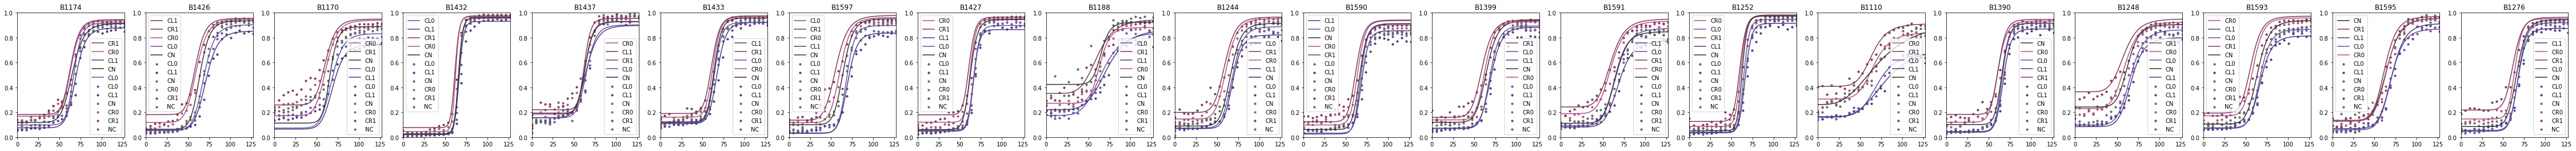

In [19]:
summary_groups = ["cue_id", "cue_direction", "cueing", "pos_bin"]
summary_data = {}
fig, axs = plt.subplots(ncols = len(subjects), nrows = 1, figsize=(4*len(subjects), 4))
for bi, bird in enumerate(tqdm(subjects)):
    
    summary_data[bird] = sum_data(behav_data[bird], groups=summary_groups)

    ax = axs.flatten()[bi]
    plot_summary_data(bird, summary_data[bird], bins, ax=ax, lines=False, error=False)
    ax.set_title(bird)
    bird_fit_df = fit_df[fit_df.bird == bird]
    for cue_id in bird_fit_df.cue.unique():
        if cue_id == 'NC': continue
        cue_row = bird_fit_df[bird_fit_df.cue == cue_id].iloc[0]
        ax.plot(interp_range, cue_row.y_interp, label = cue_id, color = cdcp_colors["cue_pal"][cue_id])
    ax.legend()
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


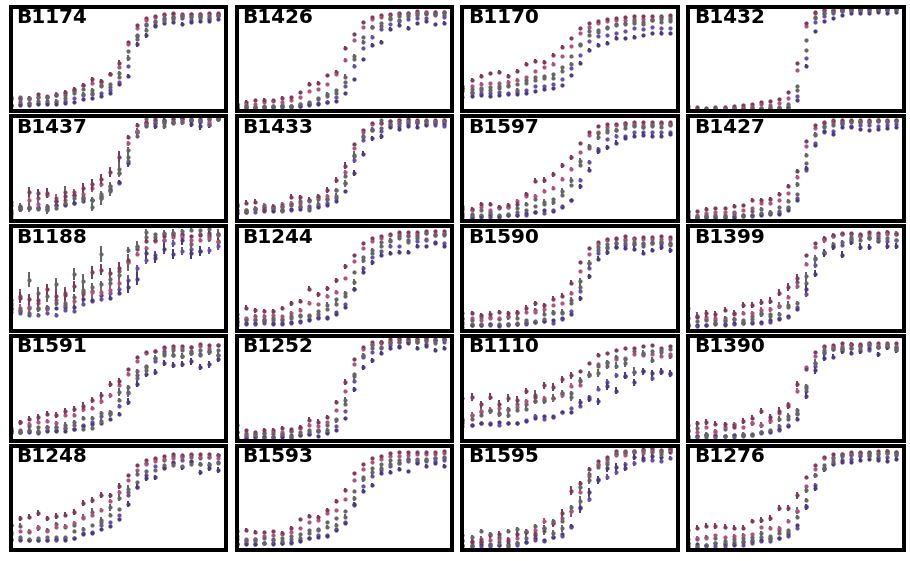

In [20]:
summary_groups = ["cue_id", "cue_direction", "cueing", "pos_bin"]
summary_data = {}
fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(16, 10),gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.05,
    })
for bi, bird in enumerate(tqdm(subjects)):
    summary_data[bird] = sum_data(behav_data[bird], groups=summary_groups)
    ax = axs.flatten()[bi]
    #if bi % 4 == 0:
    #    ax.set_ylabel('P(PR)', fontsize=22)
    plot_summary_data(
        bird,
        summary_data[bird][-10000:],
        bins=np.linspace(0,128, 25),
        ax=ax,
        lines=False,
        error=True,
        scatter=True,
        title=False,
        legend=False,
        error_size=2
    )
    ax.set_xticks([])
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    [i.set_linewidth(4) for i in ax.spines.values()]

    ax.text(
        0.025,
        0.90,
        bird,
        horizontalalignment="left",
        verticalalignment="center",
        fontweight="bold",
        fontsize=20,
        transform=ax.transAxes,
    )
    

  0%|          | 0/20 [00:00<?, ?it/s]

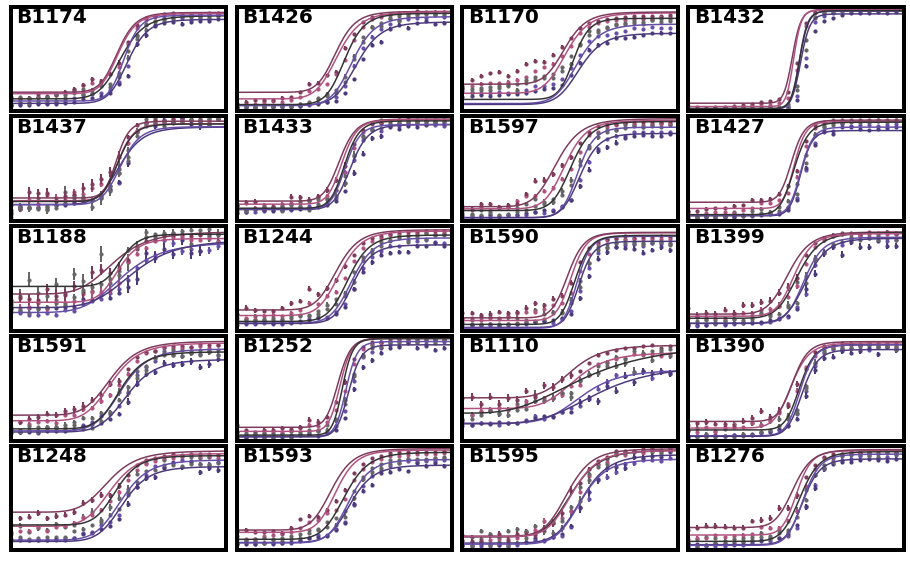

In [21]:
summary_groups = ["cue_id", "cue_direction", "cueing", "pos_bin"]
summary_data = {}
fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(16, 10),gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.05,
    })
for bi, bird in enumerate(tqdm(subjects)):
    summary_data[bird] = sum_data(behav_data[bird], groups=summary_groups)
    ax = axs.flatten()[bi]
    #if bi % 4 == 0:
    #    ax.set_ylabel('P(PR)', fontsize=22)
    plot_summary_data(
        bird,
        summary_data[bird][-10000:],
        bins=np.linspace(0,128, 25),
        ax=ax,
        lines=False,
        error=True,
        scatter=True,
        title=False,
        legend=False,
        error_size=2
    )
    ax.set_xticks([])
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    [i.set_linewidth(4) for i in ax.spines.values()]
    
    bird_fit_df = fit_df[fit_df.bird == bird]
    for cue_id in bird_fit_df.cue.unique():
        if cue_id == "NC":
            continue
        cue_row = bird_fit_df[bird_fit_df.cue == cue_id].iloc[0]
        ax.plot(interp_range, cue_row.y_interp, label = cue_id, color = cdcp_colors["cue_pal"][cue_id])
    
    ax.text(
        0.025,
        0.90,
        bird,
        horizontalalignment="left",
        verticalalignment="center",
        fontweight="bold",
        fontsize=20,
        transform=ax.transAxes,
    )
    #break

  0%|          | 0/20 [00:00<?, ?it/s]

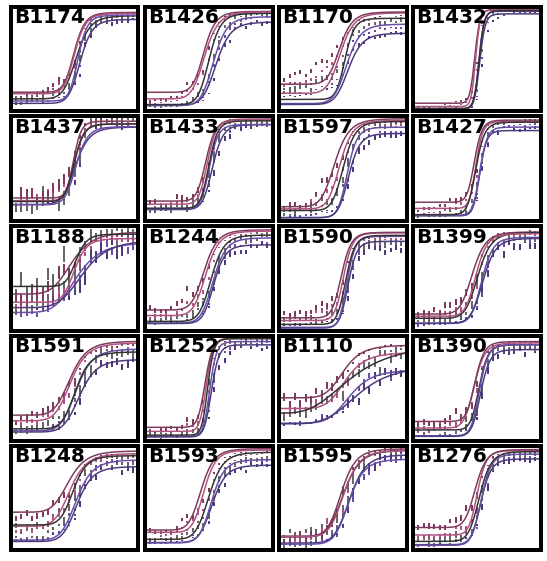

In [22]:
summary_groups = ["cue_id", "cue_direction", "cueing", "pos_bin"]
summary_data = {}
fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(9.5, 10),gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.05,
    })
for bi, bird in enumerate(tqdm(subjects)):
    summary_data[bird] = sum_data(behav_data[bird], groups=summary_groups)
    ax = axs.flatten()[bi]
    #if bi % 4 == 0:
    #    ax.set_ylabel('P(PR)', fontsize=22)
    plot_summary_data(
        bird,
        summary_data[bird],
        bins,
        ax=ax,
        lines=False,
        error=True,
        scatter=False,
        title=False,
        legend=False,
        error_size=2
    )
    # ax.set_title(bird)
    bird_fit_df = fit_df[fit_df.bird == bird]
    for cue_id in bird_fit_df.cue.unique():
        if cue_id == "NC":
            continue
        cue_row = bird_fit_df[bird_fit_df.cue == cue_id].iloc[0]
        ax.plot(interp_range, cue_row.y_interp, label = cue_id, color = cdcp_colors["cue_pal"][cue_id])
    ax.set_xticks([])
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    [i.set_linewidth(4) for i in ax.spines.values()]

    ax.text(
        0.025,
        0.90,
        bird,
        horizontalalignment="left",
        verticalalignment="center",
        fontweight="bold",
        fontsize=20,
        transform=ax.transAxes,
    )
    

ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'cue_shift', save_pdf=True)
plt.show()

## Plot fit/parameters

In [23]:
bird = 'B1170'
cue = 'CN'

In [24]:
bird_summary = sum_data(behav_data[bird], groups=summary_groups)
bird_summary = bird_summary[bird_summary.cue_id == cue]
bird_summary = bird_summary[bird_summary.cueing == True]
bird_summary[:3]

level_0 cue_id cue_direction cueing pos_bin     session                   \
                                                       mean         std  len   
125     125     CN             N   True       0  555.394958  521.150832  119   
126     126     CN             N   True       1  471.030747  495.811019  683   
127     127     CN             N   True       2  445.932927  511.641351  656   

         index                   correct                       rt            \
          mean        std  len      mean       std  len      mean       std   
125  58.773109  34.903119  119  0.789916  0.409091  119  1.353139  1.230636   
126  56.414348  34.337418  683  0.819912  0.384542  683  1.268486  1.151990   
127  56.378049  35.141247  656  0.800305  0.400076  656  1.303396  1.176152   

            reward                   punish                cue_prob            \
     len      mean       std  len      mean       std  len     mean  std  len   
125  119  0.260504  0.440766  119  0.210084  0.409091  119      0.5  0.0  119   
126  683  0.202050  0.401823  683  0.180088  0.384542  683      0.5  0.0  683   
127  656  0.214939  0.411093  656  0.199695  0.400076  656      0.5  0.0  656   

    num_stims                flip_cues           binary_choice            \
         mean       std  len      mean  std  len          mean  std  len   
125  2.882353  0.435238  119       0.0  0.0  119           0.0  0.0  119   
126  2.907760  0.369649  683       0.0  0.0  683           0.0  0.0  683   
127  2.902439  0.361836  656       0.0  0.0  656           0.0  0.0  656   

    interpolation_point                prob_cue           prob_cued_no_cue  \
                   mean       std  len     mean  std  len             mean   
125            0.000000  0.000000  119      0.8  0.0  119              0.2   
126            2.890190  1.421847  683      0.8  0.0  683              0.2   
127            7.949695  1.394285  656      0.8  0.0  656              0.2   

              response_bool                 
     std  len          mean       std  len  
125  0.0  119      0.210084  0.409091  119  
126  0.0  683      0.180088  0.384542  683  
127  0.0  656      0.199695  0.400076  656

In [25]:
bird_fit_df = fit_df[fit_df.bird == bird]
#bird_fit_df
cue_row = bird_fit_df[bird_fit_df.cue == cue].iloc[0]
cue_row

bird                                                       B1170
cue                                                           CN
n_points                                                    4148
_min                                                    0.112851
_max                                                    0.888734
_inflection                                            65.786703
_slope                                                 14.468361
model          <lmfit.minimizer.MinimizerResult object at 0x7...
y_interp       [0.11285143557024457, 0.11285143557024457, 0.1...
r_squared                                                0.51041
Name: 15, dtype: object

In [26]:
cue_row._inflection

65.78670294178777

In [27]:
import seaborn as sns

In [28]:
pal = sns.color_palette('Set1', 4)
pal_dict = {
    '_inflection': pal[0],
    '_min': pal[1],
    '_max': pal[2],
    '_slope': pal[3]
}

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


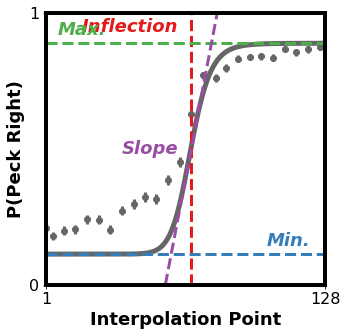

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
color = colors["cue"]["N"][0.5]

bin_mean = bird_summary.interpolation_point["mean"].values
response_mean = bird_summary.response_bool["mean"].values
response_std = bird_summary.response_bool["std"].values
response_n = bird_summary.response_bool["len"].values
response_sem = response_std / np.sqrt(response_n)

ax.scatter(
    bin_mean, response_mean, color=color,
)
ax.errorbar(
    bin_mean, response_mean, yerr=response_sem, xerr=None, color=color, lw=3, fmt="none"
)
ax.plot(interp_range, cue_row.y_interp, color=color, lw=5)


ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.set_ylabel("P(Peck Right)", fontsize=18, fontweight="bold")
ax.set_xlabel("Interpolation Point", fontsize=18, fontweight="bold")

inflection_bin = np.argmin(np.abs(interp_range - cue_row._inflection))
x = np.array([interp_range[inflection_bin - 1], interp_range[inflection_bin + 1]])
y = np.array(
    [cue_row.y_interp[inflection_bin - 1], cue_row.y_interp[inflection_bin + 1]]
)
grad = np.gradient(y, x)[0]
inf = interp_range[inflection_bin]
inf_y = cue_row._min + (cue_row._max - cue_row._min) / 2
# ax.axhline(inf_y)
xmin_slope = inf - inf_y / grad
xmax_slope = inf + (1 - inf_y) / grad

lw = 3
ls = "dashed"
ax.axvline(cue_row._inflection, color=pal_dict["_inflection"], lw=lw, ls=ls)
ax.axhline(cue_row._max, color=pal_dict["_max"], lw=lw, ls=ls)
ax.axhline(cue_row._min, color=pal_dict["_min"], lw=lw, ls=ls)
plt.plot([xmin_slope, xmax_slope], [0, 1], color=pal_dict["_slope"], lw=lw, ls=ls)

fontsize = 18
fontweight='bold'
style='italic'
ax.text(
    60,
    0.95,
    "Inflection",
    horizontalalignment="right",
    verticalalignment="center",
    fontsize=fontsize,
    color=pal_dict["_inflection"],
    fontweight=fontweight,
    style=style
)

ax.text(
    120,
    cue_row._min + 0.05,
    "Min.",
    horizontalalignment="right",
    verticalalignment="center",
    fontsize=fontsize,
    color=pal_dict["_min"],
    fontweight=fontweight,
    style=style
)
ax.text(
    5,
    cue_row._max + 0.05,
    "Max.",
    horizontalalignment="left",
    verticalalignment="center",
    fontsize=fontsize,
    color=pal_dict["_max"],
    fontweight=fontweight,
    style=style
)

ax.text(
    60,
    0.5,
    "Slope",
    horizontalalignment="right",
    verticalalignment="center",
    fontsize=fontsize,
    color=pal_dict["_slope"],
    fontweight=fontweight,
    style=style
)

ax.set_xticks([0,127])
ax.set_yticks([0,1])
ax.set_xticklabels([1,128])
ax.set_ylim([0, 1])
ax.set_xlim([0, 127])
[i.set_linewidth(4) for i in ax.spines.values()];


ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'logistic', save_pdf=True)
plt.show()

### plot variaiblity across birds

In [30]:
fit_df_interp = pd.DataFrame(
    columns=[
        "bird",
        "cue",
        "interp",
        "n_points",
        "_min",
        "_max",
        "_inflection",
        "_slope",
        "model",
        "y_interp",
        'r_squared'
    ]
)

for bird in tqdm(subjects):
    for interpolation in tqdm(behav_data[bird].interpolation.unique(), leave=False):
        for cue_id in behav_data[bird].cue_id.unique():
            if cue_id == "N":
                continue
            # subset data
            cue_df = behav_data[bird][
                (behav_data[bird].cue_id == cue_id)
                & (behav_data[bird].interpolation == interpolation)
            ]
            interp_points = cue_df.interpolation_point.values.astype("float32")
            response_points = cue_df.response_bool.values.astype("float32")
            # disclude endpoints to ensure fit is not based on binary behavior
            m = ((interp_points == 0) | (interp_points == 127)) == False
            interp_points = interp_points[m]
            response_points = response_points[m]
            # fit model
            try:
                (
                    (_min, _max, _inflection, _slope),
                    results_logistic,
                    y_model,
                    r_squared,
                ) = fit_FourParameterLogistic(interp_points, response_points)
                # model fit
                y_interp = FourParameterLogistic(
                    {"_min": _min, "_max": _max, "inflection": _inflection, "slope": _slope},
                    interp_range,
                )
            except RuntimeError as e:
                print(bird, interpolation, cue_id, e)
                continue


            fit_df_interp.loc[len(fit_df_interp)] = [
                bird,
                cue_id,
                interpolation,
                len(cue_df),
                _min,
                _max,
                _inflection,
                _slope,
                results_logistic,
                y_interp,
                r_squared
            ]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [31]:
from cdcp.paths import DATA_DIR, ensure_dir

In [32]:
ensure_dir(DATA_DIR/'behavior')

In [33]:
fit_df_interp.to_pickle(DATA_DIR/'behavior'/'fit_df_interp.pickle')

In [34]:
from cdcp.visualization.utils import get_cat_colors

In [35]:
_, pal, pal_dict = get_cat_colors(fit_df_interp.interp.values)

In [36]:
fit_df_interp[
                fit_df_interp.bird  == 'B1188'
]

,bird,cue,interp,n_points,_min,_max,_inflection,_slope,model,y_interp,r_squared
432,B1188,NC,AE,14323,0.243059,0.795827,52.187687,9.177817,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.2430591566125796, 0.2430591566125797, 0.243...",0.246354
433,B1188,CL0,AE,1738,0.171188,0.718064,56.788656,9.299922,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.1711880922211887, 0.1711880922211887, 0.171...",0.211268
434,B1188,CR1,AE,1825,0.423016,0.881038,62.695843,91.711643,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.4230162416740005, 0.4230162416740005, 0.423...",0.159892
435,B1188,CL1,AE,1818,0.227616,0.666735,68.154286,7.626080,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.22761642283277272, 0.22761642283277733, 0.2...",0.078736
436,B1188,CR0,AE,1818,0.315519,0.829896,63.288681,99.999882,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.31551884127060104, 0.31551884127060104, 0.3...",0.231240
437,B1188,CN,AE,370,0.469512,0.899254,60.000651,12.966581,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.46951227364845977, 0.46951227364845977, 0.4...",0.164603
438,B1188,NC,AF,10122,0.228087,0.924555,64.112669,7.698298,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.2280869802972938, 0.22808698029730234, 0.22...",0.360796
439,B1188,CL0,AF,1843,0.152969,1.000000,70.528896,5.593144,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.15296922081329245, 0.15296922085217146, 0.1...",0.331155
440,B1188,CR1,AF,1713,0.352980,0.976609,59.880625,5.582241,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.3529795298250227, 0.3529795298997854, 0.352...",0.219029
441,B1188,CL1,AF,1887,0.239543,0.945891,71.150361,8.816165,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.23954312859687288, 0.23954312859687288, 0.2...",0.171493


  0%|          | 0/20 [00:00<?, ?it/s]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


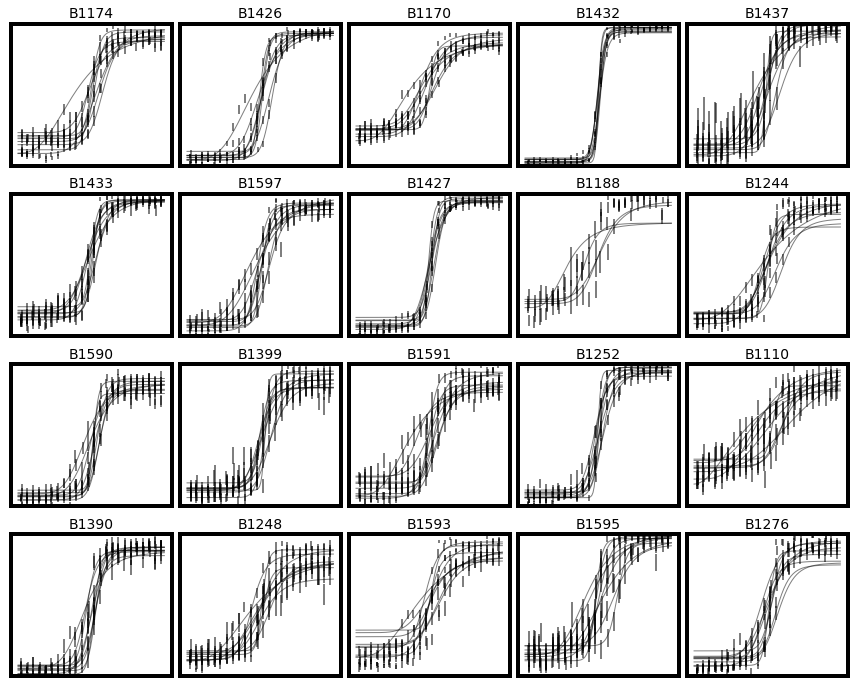

In [37]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),gridspec_kw={
        "wspace": 0.05,
    },)

color = "k"
lw = 1
cue_id = "NC"
alpha = 0.5

birds_to_plot = behav_data.keys()
bird_colors = {
    i: j for i, j in zip(birds_to_plot, sns.color_palette("Dark2", len(birds_to_plot)))
}

summary_groups = [
    "cue_id",
    "cue_direction",
    "cueing",
    "pos_bin",
    "left_stim",
    "right_stim",
]

summary_data_stims = {}
for bi, bird in enumerate(tqdm(birds_to_plot)):
    ax = axs.flatten()[bi]
    behav_data[bird]["interpolation_point"] = behav_data[bird][
        "interpolation_point"
    ].values.astype("int")
    bird_data = behav_data[bird]
    m = bird_data.interpolation_point.isin([0,127]) == False
    bird_data = bird_data[m]
    summary_data_stims[bird] = sum_data(bird_data, groups=summary_groups)
    left_stims = np.unique(summary_data_stims[bird].left_stim)
    right_stims = np.unique(summary_data_stims[bird].right_stim)

    for lsi, left_stim in enumerate(left_stims):
        for rsi, right_stim in enumerate(right_stims):
            interp = left_stim + right_stim
            color = pal_dict[interp]
            color = 'k'
            
            stim_df = summary_data_stims[bird][
                (summary_data_stims[bird].left_stim == left_stim)
                & (summary_data_stims[bird].right_stim == right_stim)
            ]

            stim_summary = stim_df[
                (stim_df.cue_id == cue_id) & (stim_df.cueing == True)
            ]

            bin_mean = stim_summary.interpolation_point["mean"].values
            response_mean = stim_summary.response_bool["mean"].values
            response_std = stim_summary.response_bool["std"].values
            response_n = stim_summary.response_bool["len"].values
            response_sem = response_std / np.sqrt(response_n)

            if False:
                ax.scatter(
                    bin_mean,
                    response_mean,
                    color=color,
                    s=10,
                    alpha=alpha,
                )
            if True:
                ax.errorbar(
                    bin_mean,
                    response_mean,
                    yerr=response_sem,
                    xerr=None,
                    color=color,
                    lw=2,
                    alpha=alpha,
                    fmt="none",
                )

            cue_row = fit_df_interp[
                (fit_df_interp.bird == bird)
                & (fit_df_interp.cue == cue_id)
                & (fit_df_interp.interp == (left_stim + right_stim))
            ].iloc[0]
            ax.plot(
                interp_range,
                cue_row.y_interp,
                label=cue_id,
                lw=lw,
                color=color,
                alpha=alpha,
            )
    ax.set_xticks([])
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    [i.set_linewidth(4) for i in ax.spines.values()]
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    if False:
        
        ax.text(
            6,
            0.85,
            bird,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=16,
            color="black",
            fontweight="bold",
        )
            #ax.set_ylim([0, 1])
            #ax.set_xlim([0, 127])
    ax.set_title(bird, fontsize=14)
    #break
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

# axs[1].set_ylabel("P(Peck Right)", fontsize=18, fontweight="bold")
# ax.set_xlabel("Interpolation Point", fontsize=18, fontweight="bold")

ensure_dir(FIGURE_DIR / "behavioral_results")
save_fig(FIGURE_DIR / 'behavioral_results' / 'all_birds_fits', save_pdf=True)
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


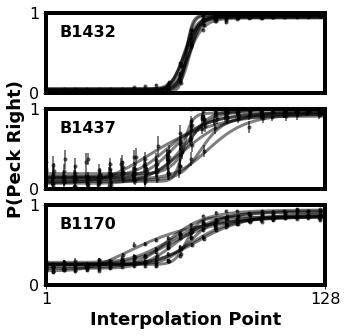

In [38]:
fig, axs = plt.subplots(nrows=3, figsize=(5, 5))

color = "k"
lw = 3
cue_id = "NC"
alpha = 0.5

birds_to_plot = ["B1432",  "B1437", "B1170",]
bird_colors = {
    i: j for i, j in zip(birds_to_plot, sns.color_palette("Dark2", len(birds_to_plot)))
}

summary_groups = [
    "cue_id",
    "cue_direction",
    "cueing",
    "pos_bin",
    "left_stim",
    "right_stim",
]

summary_data_stims = {}
for bi, bird in enumerate(birds_to_plot):
    ax = axs[bi]
    behav_data[bird]["interpolation_point"] = behav_data[bird][
        "interpolation_point"
    ].values.astype("int")

    summary_data_stims[bird] = sum_data(behav_data[bird], groups=summary_groups)
    left_stims = np.unique(summary_data_stims[bird].left_stim)
    right_stims = np.unique(summary_data_stims[bird].right_stim)

    color = bird_colors[bird]
    color = 'k'

    for lsi, left_stim in enumerate(left_stims):
        for rsi, right_stim in enumerate(right_stims):
            stim_df = summary_data_stims[bird][
                (summary_data_stims[bird].left_stim == left_stim)
                & (summary_data_stims[bird].right_stim == right_stim)
            ]

            stim_summary = stim_df[
                (stim_df.cue_id == cue_id) & (stim_df.cueing == True)
            ]

            bin_mean = stim_summary.interpolation_point["mean"].values
            response_mean = stim_summary.response_bool["mean"].values
            response_std = stim_summary.response_bool["std"].values
            response_n = stim_summary.response_bool["len"].values
            response_sem = response_std / np.sqrt(response_n)

            if True:
                ax.scatter(
                    bin_mean, response_mean, color=color, s=10, alpha=alpha,
                )
                ax.errorbar(
                    bin_mean,
                    response_mean,
                    yerr=response_sem,
                    xerr=None,
                    color=color,
                    lw=2,
                    alpha=alpha,
                    fmt="none",
                )
                # ax.plot(interp_range, cue_row.y_interp, color=color, lw=5)

            cue_row = fit_df_interp[
                (fit_df_interp.bird == bird)
                & (fit_df_interp.cue == cue_id)
                & (fit_df_interp.interp == (left_stim + right_stim))
            ].iloc[0]

            ax.plot(
                interp_range,
                cue_row.y_interp,
                label=cue_id,
                lw=lw,
                color=color,
                alpha=alpha,
            )
    ax.set_xticks([])
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 1])
    [i.set_linewidth(4) for i in ax.spines.values()]
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.text(
        6,
        0.85,
        bird,
        horizontalalignment="left",
        verticalalignment="top",
        fontsize=16,
        color=color,
        fontweight="bold",
    )
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 127])
        
ax.set_xticks([0, 127])
ax.set_yticks([0, 1])
ax.set_xticklabels([1, 128])

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

axs[1].set_ylabel("P(Peck Right)", fontsize=18, fontweight="bold")
ax.set_xlabel("Interpolation Point", fontsize=18, fontweight="bold")


ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'example_birds_fits', save_pdf=True)
plt.show()

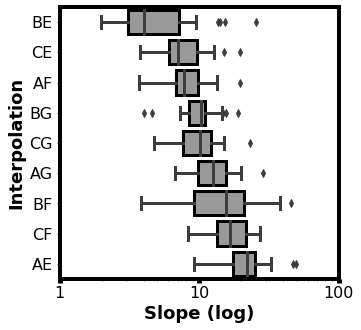

In [39]:
grouped = fit_df_interp[fit_df_interp.cue == "NC"].groupby("interp")
fit_df_interp_sorted_average = (
    pd.DataFrame({col: vals["_slope"] for col, vals in grouped})
    .mean()
    .sort_values(ascending=True)
)
# fit_df_interp_sorted_average

fig, ax = plt.subplots(figsize=(5,5))
g = sns.boxplot(
    y="interp",
    x="_slope",
    data=fit_df_interp[fit_df_interp.cue == "NC"],
    ax=ax,
    order=fit_df_interp_sorted_average.index,
    linewidth = 3,
    palette=None,
    orient='h',
    #whis=0
)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('#999999')

g.set(xscale="log")



ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.set_xticks([1, 10, 100])
ax.set_xticklabels(['1', '10', '100'])
ax.xaxis.set_tick_params(width=5)

[i.set_linewidth(4) for i in ax.spines.values()];
ax.set_xlabel("Slope (log)", fontsize=18, fontweight="bold")
ax.set_ylabel("Interpolation", fontsize=18, fontweight="bold")

ensure_dir(FIGURE_DIR / 'behavioral_results')
#save_fig(FIGURE_DIR / 'behavioral_results' / 'interpolation_slopes', save_pdf=True)
plt.show()

In [186]:
pal_dict

{'AE': array([0.12156863, 0.46666667, 0.70588235]),
 'AF': array([0.58039216, 0.40392157, 0.74117647]),
 'AG': array([0.83921569, 0.15294118, 0.15686275]),
 'BE': array([0.7372549 , 0.74117647, 0.13333333]),
 'BF': array([0.49803922, 0.49803922, 0.49803922]),
 'BG': array([0.54901961, 0.3372549 , 0.29411765]),
 'CE': array([0.89019608, 0.46666667, 0.76078431]),
 'CF': array([0.17254902, 0.62745098, 0.17254902]),
 'CG': array([1.        , 0.49803922, 0.05490196])}

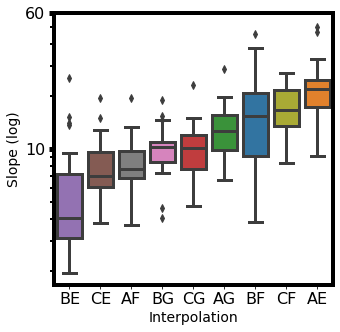

In [40]:
grouped = fit_df_interp[fit_df_interp.cue == "NC"].groupby("interp")
fit_df_interp_sorted_average = (
    pd.DataFrame({col: vals["_slope"] for col, vals in grouped})
    .mean()
    .sort_values(ascending=True)
)
# fit_df_interp_sorted_average

fig, ax = plt.subplots(figsize=(5,5))
g = sns.boxplot(
    x="interp",
    y="_slope",
    data=fit_df_interp[fit_df_interp.cue == "NC"],
    ax=ax,
    order=fit_df_interp_sorted_average.index,
    linewidth = 3,
    palette=pal_dict,
)
#for i,box in enumerate(ax.artists):
#    box.set_edgecolor('black')
#    box.set_facecolor('#999999')

g.set(yscale="log")

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.set_yticks([10, 60])
ax.set_yticklabels(['10', '60'])
ax.yaxis.set_tick_params(width=5, length = 5)
ax.yaxis.set_tick_params(width=2, length = 4, which='minor')

[i.set_linewidth(4) for i in ax.spines.values()];
ax.set_ylabel("Slope (log)", fontsize=14)
ax.set_xlabel("Interpolation", fontsize=14)
ax.legend([],[], frameon=False)

ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'interpolation_slopes_colored', save_pdf=True)
plt.show()

### plot shift across birds
- first plot the general shift across birds, then below it plot a bayesian model prediction for shift

In [41]:
behav_all = pd.concat([behav_data[bird][-20000:] for bi, bird in enumerate(tqdm(subjects))])

  0%|          | 0/20 [00:00<?, ?it/s]

In [42]:
fit_df_all = pd.DataFrame(
    columns=[
        "bird",
        "cue",
        "n_points",
        "_min",
        "_max",
        "_inflection",
        "_slope",
        "model",
        "y_interp",
        "r_squared",
    ]
)
bird = "all"
for cue_id in tqdm(behav_all.cue_id.unique()):
    #print(cue_id)
    if cue_id == "N":
        continue
    # subset data
    cue_df = behav_all[behav_all.cue_id == cue_id]
    interp_points = cue_df.interpolation_point.values.astype("float32")
    response_points = cue_df.response_bool.values.astype("float32")
    # fit model

    (
        (_min, _max, _inflection, _slope),
        results_logistic,
        y_model,
        r_squared,
    ) = fit_FourParameterLogistic(interp_points, response_points)
    # model fit
    y_interp = FourParameterLogistic(
        {"_min": _min, "_max": _max, "inflection": _inflection, "slope": _slope},
        interp_range,
    )
    fit_df_all.loc[len(fit_df_all)] = [
        bird,
        cue_id,
        len(cue_df),
        _min,
        _max,
        _inflection,
        _slope,
        results_logistic,
        y_interp,
        r_squared,
    ]
    print(len(fit_df_all))

  0%|          | 0/6 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


1
2
3
4
5
6


In [43]:
behav_all[:3]

,session,index,type_,stimulus,class_,response,correct,rt,reward,punish,cue_class,cue_id,cue_prob,num_stims,flip_cues,binary_choice,cueing,left_stim,right_stim,interpolation_point,prob_cue,prob_cued_no_cue,data_file,response_bool,interpolation,pos_bin,cue_direction,self_initiated
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-12 14:59:53.841878,1379,113,normal,/home/bird/opdat/B1174/stimuli/BE/CR1/CR1_BE_1...,L,R,False,3.822665,False,True,CR,CR1,0.875,3,False,False,True,B,E,15,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,1,BE,3,R,NaN
2020-02-12 15:13:12.478247,1379,118,normal,/home/bird/opdat/B1174/stimuli/AF/CL1/CL1_AF_1...,L,L,True,0.406864,False,False,CL,CL1,0.875,3,False,False,True,A,F,17,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,0,AF,4,L,NaN
2020-02-12 15:13:17.327046,1379,119,normal,/home/bird/opdat/B1174/stimuli/CE/CR0/CR0_CE_0...,R,R,True,0.234703,True,False,CR,CR0,0.750,3,False,False,True,C,E,101,0.8,0.2,/mnt/cube/RawData/Magpi/B1174/B1174_trialdata_...,1,CE,20,R,NaN


In [44]:
behav_all['interpolation_point'] = behav_all['interpolation_point'].values.astype('int')

In [45]:
summary_groups = ["cue_id", "cue_direction", "cueing", "pos_bin"]

summary_data_all = sum_data(
    behav_all,
    groups=summary_groups,
)
summary_data_all  = summary_data_all[summary_data_all.cue_id != 'NC']

In [46]:
fit_df_all

,bird,cue,n_points,_min,_max,_inflection,_slope,model,y_interp,r_squared
0,all,CR1,80228,0.185079,0.963389,59.808516,10.526189,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.18507877418247276, 0.18507877418247276, 0.1...",0.412242
1,all,CL1,80379,0.065023,0.849073,68.408036,12.122421,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.06502256295168807, 0.06502256295168807, 0.0...",0.383092
2,all,CR0,79980,0.137350,0.949270,61.471740,11.140858,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.13735030623984312, 0.13735030623984312, 0.1...",0.513716
3,all,NC,63469,0.108141,0.930132,64.457487,12.137513,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.10814080277952653, 0.10814080277952653, 0.1...",0.560196
4,all,CL0,79960,0.067473,0.884673,66.794390,13.282440,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.06747342848310223, 0.06747342848310223, 0.0...",0.521128
5,all,CN,15984,0.113422,0.929891,64.614025,12.904284,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.11342196898397527, 0.11342196898397527, 0.1...",0.558988


In [47]:
cdcp_colors['cue_pal']['NC'] = '#333333'

CR1
CL1
CR0
CL0
CN


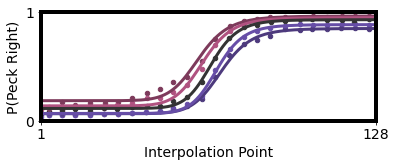

In [48]:
fig, ax = plt.subplots(figsize=(6,2))
for cue_id in fit_df_all.cue.unique():
    if cue_id == 'NC': continue
    #if cue_id != 'NC': continue
    print(cue_id)
    cue_summary = summary_data_all[summary_data_all.cue_id == cue_id]
    bin_mean = cue_summary.interpolation_point["mean"].values
    response_mean = cue_summary.response_bool["mean"].values
    response_std = cue_summary.response_bool["std"].values
    response_n = cue_summary.response_bool["len"].values
    response_sem = response_std / np.sqrt(response_n)
    color = cdcp_colors["cue_pal"][cue_id]
    ax.scatter(
        bin_mean, response_mean, color=color, s = 20
    )
    ax.errorbar(
        bin_mean, response_mean, yerr=response_sem, xerr=None, color=color, lw=3, fmt="none"
    )
    
    cue_row = fit_df_all[fit_df_all.cue == cue_id].iloc[0]
    ax.plot(interp_range, cue_row.y_interp, color=color, lw=3)

ax.set_xticks([0,127])
ax.set_yticks([0,1])
ax.set_xticklabels([1,128])
ax.set_ylim([0, 1])
ax.set_xlim([0, 127])
[i.set_linewidth(4) for i in ax.spines.values()];

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_ylabel("P(Peck Right)", fontsize=14)
ax.set_xlabel("Interpolation Point", fontsize=14);

ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'cue_shift_all', save_pdf=True)
plt.show()

#### fit bayesian model

In [49]:
x_true = np.arange(128)
decision_boundary = np.zeros(len(x_true))
decision_boundary[x_true > 63] = 1

In [50]:
condition_types = [0.125, 0.25, 0.5, 0.75, 0.875]
midpoint = 63
prior_probability = {ct: np.zeros(len(x_true))+ct for ct in condition_types}
for ct in condition_types: prior_probability[ct][x_true > midpoint]  = 1-ct 

In [51]:
from joblib import Parallel, delayed
from cdcp.behavior.bayesian import fit_bayesian_model

In [52]:
condition_probs = {
    "NC": 0.5,
    "N": 0.5,
    "CL0": 0.75,
    "CN": 0.5,
    "CR1": 0.875,
    "CL1": 0.875,
    "CR0": 0.75,
}

In [53]:
training_size = 10000000  # how much data used to fit
with Parallel(n_jobs=1, verbose=10) as parallel:
    bayesian_models = parallel(
        delayed(fit_bayesian_model)(
        'All',
        cue,
        condition_probs[cue],
        responses = behav_all[
            (behav_all["cue_prob"] == condition_probs[cue])
            & (behav_all["cue_id"] == cue)
        ]["response_bool"].values[-training_size:],
        positions = behav_all[
            (behav_all["cue_prob"] == condition_probs[cue])
            & (behav_all["cue_id"] == cue)
        ]["interpolation_point"].values[-training_size:],
        x_true = x_true,
        prior = prior_probability[condition_probs[cue]]
        if cue != "N"
        else prior_probability[0.5],
        decision_boundary = decision_boundary,
        verbose=False,
    )
        for cue in tqdm(np.unique(behav_all['cue_id']))
    )

  0%|          | 0/6 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.7min finished


In [54]:
params_dict = pd.DataFrame(
    [list(i.params.valuesdict().values()) for i in bayesian_models if i != None],
    columns=list(bayesian_models[0].params.keys()),
).reset_index()
bayes_model_fits = pd.DataFrame(
    [[i, "all", cue] for i, cue in enumerate(np.unique(behav_all["cue_id"]))],
    columns=["i", "bird", "cue"],
)[np.array(bayesian_models) != None].reset_index()
bayes_model_fits["results"] = np.array(bayesian_models)[
    np.array(bayesian_models) != None
]
bayes_model_fits = pd.concat((bayes_model_fits, params_dict), axis=1)
bayes_model_fits["params_dict"] = [
    i.params.valuesdict()
    for i in np.array(bayesian_models)[np.array(bayesian_models) != None]
]
bayes_model_fits

,index,i,bird,cue,results,index,sigma_likelihood,alpha_overall_attention,beta_categorical_attention,delta_cue_attention,gamma_side_bias,params_dict
0,0,0,all,CL0,<lmfit.minimizer.MinimizerResult object at 0x7...,0,8.479146,0.094958,0.082829,0.962851,0.498662,"{'sigma_likelihood': 8.479145877503608, 'alpha..."
1,1,1,all,CL1,<lmfit.minimizer.MinimizerResult object at 0x7...,1,9.297012,0.003795,0.227327,0.935385,0.746883,"{'sigma_likelihood': 9.297012178827913, 'alpha..."
2,2,2,all,CN,<lmfit.minimizer.MinimizerResult object at 0x7...,2,8.644963,0.140264,0.054665,0.000191,0.553297,"{'sigma_likelihood': 8.644962935709838, 'alpha..."
3,3,3,all,CR0,<lmfit.minimizer.MinimizerResult object at 0x7...,3,9.773178,0.076080,0.106810,0.999426,0.611117,"{'sigma_likelihood': 9.773177644479514, 'alpha..."
4,4,4,all,CR1,<lmfit.minimizer.MinimizerResult object at 0x7...,4,10.400568,0.213341,0.005261,0.995445,0.810847,"{'sigma_likelihood': 10.400567554316165, 'alph..."
5,5,5,all,NC,<lmfit.minimizer.MinimizerResult object at 0x7...,5,9.302131,0.046858,0.140169,0.000432,0.546666,"{'sigma_likelihood': 9.302130630016942, 'alpha..."


#### bayesian model fit

In [55]:
from cdcp.behavior.bayesian import bayesian_model

CL0 0.9628514004984718
CL1 0.9353848733000059
CN 0.00019089197078275832
CR0 0.999426165097168
CR1 0.9954454035678135


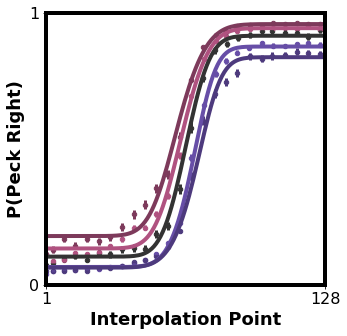

In [56]:
fig, ax = plt.subplots(figsize=(5,5))
for idx, row in bayes_model_fits.iterrows():
    cue_id = row.cue
    if cue_id == 'NC': continue
    #if cue_id != 'NC': continue
    #print(cue_id)
    cue_summary = summary_data_all[summary_data_all.cue_id == cue_id]
    bin_mean = cue_summary.interpolation_point["mean"].values
    response_mean = cue_summary.response_bool["mean"].values
    response_std = cue_summary.response_bool["std"].values
    response_n = cue_summary.response_bool["len"].values
    response_sem = response_std / np.sqrt(response_n)
    color = cdcp_colors["cue_pal"][cue_id]
    ax.scatter(
        bin_mean, response_mean, color=color, s = 20
    )
    ax.errorbar(
        bin_mean, response_mean, yerr=response_sem, xerr=None, color=color, lw=3, fmt="none"
    )
    
    condition_type = condition_probs[cue_id]
    prior = prior_probability[condition_type]
    params_dict = row.params_dict
    print(cue_id, params_dict['delta_cue_attention'])
    model_y, posterior_probability, likelihood = bayesian_model(
        params_dict, x_true, prior, decision_boundary
    )
    ax.plot(
        x_true, model_y, color=color, lw=4,
    )
    

ax.set_xticks([0,127])
ax.set_yticks([0,1])
ax.set_xticklabels([1,128])
ax.set_ylim([0, 1])
ax.set_xlim([0, 127])
[i.set_linewidth(4) for i in ax.spines.values()];

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.set_ylabel("P(Peck Right)", fontsize=18, fontweight="bold")
ax.set_xlabel("Interpolation Point", fontsize=18, fontweight="bold");

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


CL0 0.4076840940875978
CL1 0.3895233698903196
CN 0.4085985052969829
CR0 0.4080501752410788
CR1 0.3926357770270043


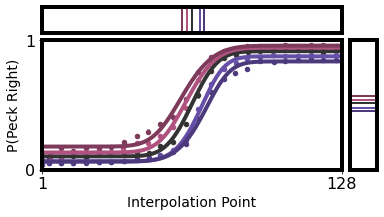

In [57]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(6, 3),
    gridspec_kw={
        "height_ratios": [1, 5],
        "width_ratios": [11, 1],
        "hspace": 0.1,
        "wspace": 0.05,
    },
)


ax = axs[0, 0]
ax.set_xticks([], [])
ax.set_yticks([])
plt.tick_params(axis="both", which="major", labelsize=16)
[i.set_linewidth(4) for i in ax.spines.values()]
ax.set_xlim([0, 127])

ax = axs[0, 1]
ax.axis("off")

ax = axs[1, 1]
ax.set_xticks([])
ax.set_yticks([])
[i.set_linewidth(4) for i in ax.spines.values()]
ax.set_ylim([0, 1])

ax = axs[1, 0]
ax.set_ylabel("P(Peck Right)", fontsize=18, fontweight="bold")
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis="both", which="major", labelsize=16)

ax = axs[1,0]
for idx, row in bayes_model_fits.iterrows():
    cue_id = row.cue
    if cue_id == 'NC': continue
    #if cue_id != 'NC': continue
    #print(cue_id)
    cue_summary = summary_data_all[summary_data_all.cue_id == cue_id]
    bin_mean = cue_summary.interpolation_point["mean"].values
    response_mean = cue_summary.response_bool["mean"].values
    response_std = cue_summary.response_bool["std"].values
    response_n = cue_summary.response_bool["len"].values
    response_sem = response_std / np.sqrt(response_n)
    color = cdcp_colors["cue_pal"][cue_id]
    ax.scatter(
        bin_mean, response_mean, color=color, s = 20
    )
    ax.errorbar(
        bin_mean, response_mean, yerr=response_sem, xerr=None, color=color, lw=3, fmt="none"
    )
    
    condition_type = condition_probs[cue_id]
    prior = prior_probability[condition_type]
    params_dict = row.params_dict
    #print(cue_id, params_dict['delta_cue_attention'])
    model_y, posterior_probability, likelihood = bayesian_model(
        params_dict, x_true, prior, decision_boundary
    )
    ax.plot(
        x_true, model_y, color=color, lw=4,
    )
    
    (
        (_min, _max, _inflection, _slope),
        results_logistic,
        y_model,
        r_squared,
    ) = fit_FourParameterLogistic(x_true, model_y)
    axs[0, 0].axvline(_inflection, color=color, lw=2)
    
    axs[1, 1].axhline(
        (_min+(_max - _min) / 2), color=color, lw =2
    )
    print(cue_id, (_max - _min) / 2)
    
ax.set_xticks([0,127])
ax.set_yticks([0,1])
ax.set_xticklabels([1,128])
ax.set_ylim([0, 1])
ax.set_xlim([0, 127])
[i.set_linewidth(4) for i in ax.spines.values()];

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.set_ylabel("P(Peck Right)", fontsize=14, fontweight="normal")
ax.set_xlabel("Interpolation Point", fontsize=14);


ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'all_birds_shift', save_pdf=True)
plt.show()

### plot the model prediction, if attention & side bias are known

CL0 0.9628514004984718
CL1 0.9353848733000059
CR0 0.999426165097168
CR1 0.9954454035678135


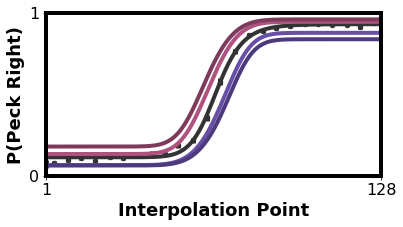

In [58]:
cue_id = 'CN'

fig, ax = plt.subplots(figsize=(6,3))

no_cue_row = bayes_model_fits[bayes_model_fits.cue == cue_id].iloc[0]
no_cue_row

cue_summary = summary_data_all[summary_data_all.cue_id == cue_id]
bin_mean = cue_summary.interpolation_point["mean"].values
response_mean = cue_summary.response_bool["mean"].values
response_std = cue_summary.response_bool["std"].values
response_n = cue_summary.response_bool["len"].values
response_sem = response_std / np.sqrt(response_n)
color = cdcp_colors["cue_pal"][cue_id]
ax.scatter(
    bin_mean, response_mean, color=color, s = 20
)
ax.errorbar(
    bin_mean, response_mean, yerr=response_sem, xerr=None, color=color, lw=5, fmt="none"
)

cue_row = fit_df_all[fit_df_all.cue == cue_id].iloc[0]
ax.plot(interp_range, cue_row.y_interp, color=color, lw=4)

params_dict = no_cue_row.params_dict
params_dict['alpha_overall_attention'] = (
    params_dict['alpha_overall_attention'] + 
    params_dict['beta_categorical_attention']
)/2
params_dict['beta_categorical_attention'] = (
    params_dict['alpha_overall_attention'] + 
    params_dict['beta_categorical_attention']
)/2

for idx, row in bayes_model_fits.iterrows():
    cue_id = row.cue
    if cue_id in ['CN', 'NC']: continue
    
    color = cdcp_colors["cue_pal"][cue_id]

    condition_type = condition_probs[cue_id]
    prior = prior_probability[condition_type]
    
    params_dict = no_cue_row.params_dict
    params_dict['delta_cue_attention'] = row.params_dict['delta_cue_attention']
    params_dict['alpha_overall_attention'] = row.params_dict['alpha_overall_attention']
    params_dict['beta_categorical_attention'] = row.params_dict['beta_categorical_attention']
    params_dict['gamma_side_bias'] = row.params_dict['gamma_side_bias']

    print(cue_id, params_dict['delta_cue_attention'])
    model_y, posterior_probability, likelihood = bayesian_model(
        params_dict, x_true, prior, decision_boundary
    )
    ax.plot(
        x_true, model_y, color=color, lw=4,
    )


ax.set_xticks([0,127])
ax.set_yticks([0,1])
ax.set_xticklabels([1,128])
ax.set_ylim([0, 1])
ax.set_xlim([0, 127])
[i.set_linewidth(4) for i in ax.spines.values()];

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.set_ylabel("P(Peck Right)", fontsize=18, fontweight="bold")
ax.set_xlabel("Interpolation Point", fontsize=18, fontweight="bold");

CL0 0.1
CL1 0.1
CR0 0.1
CR1 0.1


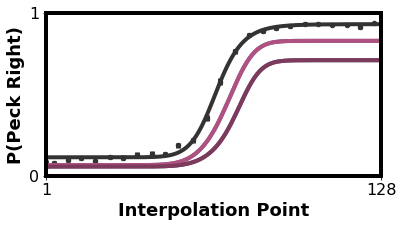

In [59]:
cue_id = 'CN'

fig, ax = plt.subplots(figsize=(6,3))

no_cue_row = bayes_model_fits[bayes_model_fits.cue == cue_id].iloc[0]
no_cue_row

cue_summary = summary_data_all[summary_data_all.cue_id == cue_id]
bin_mean = cue_summary.interpolation_point["mean"].values
response_mean = cue_summary.response_bool["mean"].values
response_std = cue_summary.response_bool["std"].values
response_n = cue_summary.response_bool["len"].values
response_sem = response_std / np.sqrt(response_n)
color = cdcp_colors["cue_pal"][cue_id]
ax.scatter(
    bin_mean, response_mean, color=color, s = 20
)
ax.errorbar(
    bin_mean, response_mean, yerr=response_sem, xerr=None, color=color, lw=5, fmt="none"
)

cue_row = fit_df_all[fit_df_all.cue == cue_id].iloc[0]
ax.plot(interp_range, cue_row.y_interp, color=color, lw=4)

params_dict = no_cue_row.params_dict
params_dict['alpha_overall_attention'] = (
    params_dict['alpha_overall_attention'] + 
    params_dict['beta_categorical_attention']
)/2
params_dict['beta_categorical_attention'] = (
    params_dict['alpha_overall_attention'] + 
    params_dict['beta_categorical_attention']
)/2

for idx, row in bayes_model_fits.iterrows():
    cue_id = row.cue
    if cue_id in ['CN', 'NC']: continue
    
    color = cdcp_colors["cue_pal"][cue_id]

    condition_type = condition_probs[cue_id]
    prior = prior_probability[condition_type]
    
    params_dict = no_cue_row.params_dict
    params_dict['delta_cue_attention'] = 0.1
    params_dict['alpha_overall_attention'] = 0.1
    params_dict['beta_categorical_attention'] = 0.1
    params_dict['gamma_side_bias'] = 0.5

    print(cue_id, params_dict['delta_cue_attention'])
    model_y, posterior_probability, likelihood = bayesian_model(
        params_dict, x_true, prior, decision_boundary
    )
    ax.plot(
        x_true, model_y, color=color, lw=4,
    )


ax.set_xticks([0,127])
ax.set_yticks([0,1])
ax.set_xticklabels([1,128])
ax.set_ylim([0, 1])
ax.set_xlim([0, 127])
[i.set_linewidth(4) for i in ax.spines.values()];

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.set_ylabel("P(Peck Right)", fontsize=18, fontweight="bold")
ax.set_xlabel("Interpolation Point", fontsize=18, fontweight="bold");

In [60]:
params_dict

OrderedDict([('sigma_likelihood', 8.644962935709838),
             ('alpha_overall_attention', 0.1),
             ('beta_categorical_attention', 0.1),
             ('delta_cue_attention', 0.1),
             ('gamma_side_bias', 0.5)])

##### fit 4 parameter logistic across birds

### plot inflection point by cue probability

In [61]:
cue_strength_dict = {'CL0': 0.75, 'CL1': 0.875, 'CN': 0.5, 'CR0': 0.25, 'CR1': 0.125, 'NC': 0.5}
fit_df_interp['cue_strength'] = [cue_strength_dict[i] for i in list(fit_df_interp.cue.values)]

In [62]:
len(fit_df_interp.cue_strength)

1050

In [63]:
import scipy.stats
correlation, p_value = scipy.stats.pearsonr(fit_df_interp.cue_strength, fit_df_interp._inflection)
correlation, p_value 

(0.44657357042641443, 1.3241552406652404e-52)

In [64]:
logistic_param_summary_df_bird = (
    fit_df_interp[np.array(["cue_strength", "cue", "bird", "_min", "_max", "_inflection", "_slope"])]
    .groupby(["cue", "bird"])
    .agg([np.mean, np.std, len])
)
logistic_param_summary_df_bird = logistic_param_summary_df_bird[logistic_param_summary_df_bird.index != 'NC']
logistic_param_summary_df_bird[:3]

cue_strength               _min                    _max            \
                  mean  std len      mean       std len      mean       std   
cue bird                                                                      
CL0 B1110         0.75  0.0   9  0.176928  0.033156   9  0.722800  0.128132   
    B1170         0.75  0.0   9  0.183070  0.021180   9  0.815630  0.053295   
    B1174         0.75  0.0   9  0.103654  0.018589   9  0.907112  0.043815   

              _inflection                   _slope                
          len        mean       std len       mean       std len  
cue bird                                                          
CL0 B1110   9   72.364556  8.805987   9   7.723940  3.853826   9  
    B1170   9   64.090438  3.432081   9  10.731177  6.540666   9  
    B1174   9   66.077853  2.552536   9  16.071069  8.594091   9

In [65]:
logistic_param_summary_df = (
    fit_df_interp[np.array(["cue_strength", "cue", "_min", "_max", "_inflection", "_slope"])]
    .groupby(["cue"])
    .agg([np.mean, np.std, len])
)
logistic_param_summary_df = logistic_param_summary_df[logistic_param_summary_df.index != 'NC']

In [66]:
logistic_param_summary_df[:3]

cue_strength                _min                     _max                 \
            mean  std  len      mean       std  len      mean       std  len   
cue                                                                            
CL0        0.750  0.0  175  0.088771  0.049561  175  0.879235  0.079919  175   
CL1        0.875  0.0  175  0.090552  0.049139  175  0.858366  0.094428  175   
CN         0.500  0.0  175  0.148465  0.081768  175  0.911790  0.064033  175   

    _inflection                    _slope                  
           mean       std  len       mean        std  len  
cue                                                        
CL0   66.985470  4.625896  175  15.194603  11.152280  175  
CL1   68.921894  6.166055  175  14.702911  11.271704  175  
CN    64.894208  5.699959  175  17.369871  16.355342  175

In [67]:
len(logistic_param_summary_df)

5

In [68]:
cue_strength = logistic_param_summary_df.cue_strength['mean'].values
inflection_point = logistic_param_summary_df._inflection['mean'].values
inf_pt_std = logistic_param_summary_df._inflection['std'].values

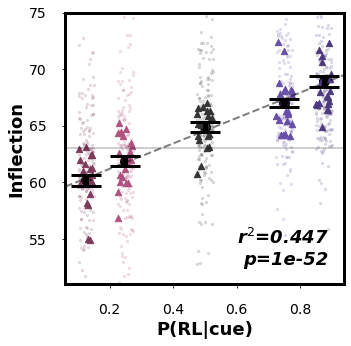

In [69]:
fig, ax = plt.subplots(figsize=(5, 5))
# ax.scatter(cue_strength, inflection_point)
# ax.errorbar(cue_strength, inflection_point, yerr=inf_pt_std, xerr=None, lw=3)
for idx, row in logistic_param_summary_df.iterrows():
    ax.scatter(
        [row.cue_strength["mean"]],
        [row._inflection["mean"]],
        # color=cdcp_colors["cue_pal"][row.name],
        color="k",
        s=100,
    )
    ax.errorbar(
        [row.cue_strength["mean"]],
        [row._inflection["mean"]],
        yerr=[row._inflection["std"] / np.sqrt(row._inflection["len"])],
        # color=cdcp_colors["cue_pal"][row.name],
        color="k",
        lw=5,
        #elinewidth=15,
        #barsabove=True,
        capsize=15, capthick=3
    )
    ax.scatter(
        fit_df_interp[fit_df_interp["cue"] == row.name].cue_strength
        + (
            np.random.uniform(
                size=len(fit_df_interp[fit_df_interp["cue"] == row.name].cue_strength)
            )
            - 0.5
        )
        * 0.05,
        fit_df_interp[fit_df_interp["cue"] == row.name]._inflection,
        color=cdcp_colors["cue_pal"][row.name],
        s=5,
        alpha=0.15,
    )

    cue_birds = logistic_param_summary_df_bird[
        logistic_param_summary_df_bird.index.get_level_values("cue") == idx
    ]

    ax.scatter(
        np.array([cue_birds.cue_strength["mean"]])+ (
            np.random.uniform(
                size=len(cue_birds._inflection["mean"])
            )
            - 0.5
        )
        * 0.05,
        [cue_birds._inflection["mean"]],
        color=cdcp_colors["cue_pal"][row.name],
        s=40,
        marker="^",
        alpha=1,
    )


bound = 12
ax.set_ylim([63 - bound, 63 + bound])
ax.axhline(63, color="k",  alpha = 0.25)# ls="dashed",

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)
ax.set_xlabel("P(RL|cue)", fontsize=18, fontweight="bold")
ax.set_ylabel("Inflection", fontsize=18, fontweight="bold")

y = fit_df_interp._inflection.values
x = fit_df_interp.cue_strength.values

m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
ax.plot(x2, m * x2 + b, color="black", lw=2, ls="dashed", alpha=0.5)
ax.set_xlim(x2)

ax.text(
    x2[1] - 0.05,
    np.array(ax.get_ylim())[0] + 5,
    "r$^2$={}\np={:g}".format(round(correlation, 3), float('{:.1g}'.format(p_value))),
    horizontalalignment="right",
    verticalalignment="top",
    fontsize=18,
    color='k',
    fontweight='bold',
    style='italic',
);

ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'inflection_shift', save_pdf=True)
plt.show()

In [70]:
 float('{:.3g}'.format(p_value))

1.32e-52

### add bayes model prediction...
- for each interpolation, get bayesian fit model on uncued
    - get inflection point with predicted cued

In [71]:
fit_df_interp[:3]

,bird,cue,interp,n_points,_min,_max,_inflection,_slope,model,y_interp,r_squared,cue_strength
0,B1174,NC,AE,14538,0.112693,0.903653,64.036638,14.918588,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.11269340812421869, 0.11269340812421869, 0.1...",0.538664,0.50
1,B1174,CL0,AE,6876,0.099140,0.880312,64.357732,27.363792,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.09913953431260725, 0.09913953431260725, 0.0...",0.533202,0.75
2,B1174,CN,AE,1606,0.131581,0.884359,64.226503,24.816837,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.1315810264285665, 0.1315810264285665, 0.131...",0.519944,0.50


##### Bayesian model fit for each interpolation x each bird x cue
- does the inferred likelihood sigma predict the shift in categorical boundary?
- larger uncertainty (higher sigma) should mean larger shift in categorical boundary
- we can compare the expected shift in the categorical boundary, given the uncued stimulus, to the true shift in the categorical boundary

In [72]:
bayes_fit_df_interp = pd.DataFrame(
    columns=[
        "bird",
        "cue",
        "interp",
        "n_points",
    ]
)
for bird in tqdm(subjects):
    for interpolation in tqdm(behav_data[bird].interpolation.unique(), leave=False):
        for cue_id in behav_data[bird].cue_id.unique():
            cue_df = behav_data[bird][
                (behav_data[bird].cue_id == cue_id)
                & (behav_data[bird].interpolation == interpolation)
            ]
            if len(cue_df) < 256:
                # skip if there's not enough data
                continue
            bayes_fit_df_interp.loc[len(bayes_fit_df_interp)] = [
                bird,
                cue_id,
                interpolation,
                len(cue_df),
            ]
bayes_fit_df_interp[:3]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

,bird,cue,interp,n_points
0,B1174,NC,AE,14538
1,B1174,CL0,AE,6876
2,B1174,CN,AE,1606


In [73]:
len(bayes_fit_df_interp)

1045

In [74]:
bayes_fit_df_interp.cue.unique()

array(['NC', 'CL0', 'CN', 'CR1', 'CL1', 'CR0'], dtype=object)

In [75]:
# fit models
training_size = 10000  # how much data used to fit
with Parallel(n_jobs=-1, verbose=10) as parallel:
    bayesian_models = parallel(
        delayed(fit_bayesian_model)(
            row.bird,
            row.cue,
            condition_probs[row.cue],
            responses=behav_data[row.bird][
                (behav_data[row.bird]["cue_prob"] == condition_probs[row.cue])
                & (behav_data[row.bird]["cue_id"] == row.cue)
                & (behav_data[row.bird]["interpolation"] == row.interp)
            ]["response_bool"].values[-training_size:],
            positions=behav_data[row.bird][
                (behav_data[row.bird]["cue_prob"] == condition_probs[row.cue])
                & (behav_data[row.bird]["cue_id"] == row.cue)
                & (behav_data[row.bird]["interpolation"] == row.interp)
            ]["interpolation_point"].values[-training_size:],
            x_true=x_true,
            prior=prior_probability[condition_probs[row.cue]]
            if cue != "N"
            else prior_probability[0.5],
            decision_boundary=decision_boundary,
            verbose=False,
        )
        for idx, row in tqdm(bayes_fit_df_interp.iterrows(), total=len(bayes_fit_df_interp))
    )

  0%|          | 0/1045 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 243 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  

In [76]:
bayes_fit_df_interp['bayesian_model'] = bayesian_models

params_dict = pd.DataFrame(
    [list(i.params.valuesdict().values()) for i in bayesian_models],
    columns=list(bayesian_models[0].params.keys()),
).reset_index()

bayes_fit_df_interp["params_dict"] = [
    i.params.valuesdict()
    for i in bayesian_models
]

bayes_fit_df_interp = pd.concat((bayes_fit_df_interp, params_dict), axis=1)
bayes_fit_df_interp[:3]

,bird,cue,interp,n_points,bayesian_model,params_dict,index,sigma_likelihood,alpha_overall_attention,beta_categorical_attention,delta_cue_attention,gamma_side_bias
0,B1174,NC,AE,14538,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 6.457730202151546, 'alpha...",0,6.457730,0.063742,0.198309,0.977811,0.473227
1,B1174,CL0,AE,6876,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 4.258037094104594, 'alpha...",1,4.258037,0.170191,0.048853,0.981746,0.484030
2,B1174,CN,AE,1606,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 4.533689892680126, 'alpha...",2,4.533690,0.130808,0.130919,0.003751,0.512038


In [77]:
### fit 4 parameter logistic to bayesian models

from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic, get_y

bayes_fit_df_interp['bayesian_slope'] = None
bayes_fit_df_interp["bayesian_min"] = None
bayes_fit_df_interp["bayesian_max"] = None
bayes_fit_df_interp["bayesian_inflection"] = None
bayes_fit_df_interp["bayesian_4param_model"] = None
#bayes_fit_df_interp["bayesian_y_interp"] = None
bayes_fit_df_interp["bayesian_r_squared"] = None

for idx, row in tqdm(bayes_fit_df_interp.iterrows(), total = len(bayes_fit_df_interp)):
    # get model y
    condition_type = condition_probs[row.cue]
    prior = prior_probability[condition_type]
    model_y, posterior_probability, likelihood = bayesian_model(
        row.params_dict, x_true, prior, decision_boundary
    )
    (
        (_min, _max, _inflection, _slope),
        results_logistic,
        y_model,
        r_squared,
    ) = fit_FourParameterLogistic(x_true, model_y)
    
    bayes_fit_df_interp.at[idx,"bayesian_min"] = _min
    bayes_fit_df_interp.at[idx,"bayesian_max"] = _max
    bayes_fit_df_interp.at[idx,"bayesian_inflection"] = _inflection
    bayes_fit_df_interp.at[idx,"bayesian_slope"] = _slope
    bayes_fit_df_interp.at[idx,"bayesian_4param_model"] = results_logistic
    #bayes_fit_df_interp.at[idx,"bayesian_y_interp"] = y_model
    bayes_fit_df_interp.at[idx,"bayesian_r_squared"] = r_squared

bayes_fit_df_interp['bayesian_abs_inflection'] = np.abs(bayes_fit_df_interp['bayesian_inflection'] - 63.5)

  0%|          | 0/1045 [00:00<?, ?it/s]

In [78]:
bayes_fit_df_interp['bayesian_abs_inflection'] = np.abs(bayes_fit_df_interp['bayesian_inflection'] - 63.5)

### Fit psychometric of bayesian model predictions for each bird x interpolation
- for each bird/interpolation, get the uncued bayesian fit, and predict the shift in inflection from the sigma and side bias parameters

In [79]:
len(bayes_fit_df_interp)

1045

In [80]:
bayes_fit_df_interp[:3]

,bird,cue,interp,n_points,bayesian_model,params_dict,index,sigma_likelihood,alpha_overall_attention,beta_categorical_attention,delta_cue_attention,gamma_side_bias,bayesian_slope,bayesian_min,bayesian_max,bayesian_inflection,bayesian_4param_model,bayesian_r_squared,bayesian_abs_inflection
0,B1174,NC,AE,14538,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 6.457730202151546, 'alpha...",0,6.457730,0.063742,0.198309,0.977811,0.473227,16.679781,0.115005,0.867629,63.530255,<lmfit.minimizer.MinimizerResult object at 0x7...,0.999859,0.030255
1,B1174,CL0,AE,6876,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 4.258037094104594, 'alpha...",1,4.258037,0.170191,0.048853,0.981746,0.484030,26.21499,0.093812,0.877038,64.859159,<lmfit.minimizer.MinimizerResult object at 0x7...,0.999885,1.359159
2,B1174,CN,AE,1606,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 4.533689892680126, 'alpha...",2,4.533690,0.130808,0.130919,0.003751,0.512038,23.784747,0.125208,0.882155,63.43971,<lmfit.minimizer.MinimizerResult object at 0x7...,0.999929,0.06029


In [81]:
params_dict

,index,sigma_likelihood,alpha_overall_attention,beta_categorical_attention,delta_cue_attention,gamma_side_bias
0,0,6.457730,6.374225e-02,0.198309,9.778110e-01,0.473227
1,1,4.258037,1.701907e-01,0.048853,9.817459e-01,0.484030
2,2,4.533690,1.308080e-01,0.130919,3.750615e-03,0.512038
3,3,1.928143,6.154681e-09,0.636797,3.374172e-07,0.981343
4,4,4.542356,9.152436e-02,0.168124,9.867472e-01,0.505752
...,...,...,...,...,...,...
1040,1040,11.341261,2.325008e-01,0.182579,9.998949e-01,0.461166
1041,1041,16.411052,1.392112e-02,0.267773,9.993078e-01,0.655591
1042,1042,9.782246,2.797558e-02,0.253250,9.789825e-01,0.574951
1043,1043,11.804600,2.238132e-01,0.033905,9.951694e-01,0.604353


In [82]:
bayes_prediction_fit_df = pd.DataFrame(
    columns = [
        "condition_type", "bird", "cue", "interp", "_min", "_max", "_inflection", "_likelihood", "_slope", "r_squared"
    ]
)

fit_not_cued = bayes_fit_df_interp[bayes_fit_df_interp.cue == 'NC']
for idx, row in tqdm(fit_not_cued.iterrows(), total=len(fit_not_cued)):
    for condition_type in [0.125, 0.25, 0.75, 0.875]:
        #for cue in ["L", "R"]:
        prior = prior_probability[condition_type]
        params_dict = row.params_dict
        params_dict["delta_cue_attention"] = 0
        params_dict["alpha_overall_attention"] = 0.5
        params_dict["beta_categorical_attention"] = 0.5
        model_y, posterior_probability, likelihood = bayesian_model(
            params_dict, x_true, prior, decision_boundary
        )
        (
            (_min, _max, _inflection, _slope),
            results_logistic,
            y_model,
            r_squared,
        ) = fit_FourParameterLogistic(x_true, model_y)

        bayes_prediction_fit_df.loc[len(bayes_prediction_fit_df)]  = [
            condition_type, row.bird, row.cue, row.interp, _min, _max, _inflection, row.sigma_likelihood, _slope, r_squared
        ]
    #break

  0%|          | 0/175 [00:00<?, ?it/s]

In [83]:
bayes_prediction_fit_df[:3]

,condition_type,bird,cue,interp,_min,_max,_inflection,_likelihood,_slope,r_squared
0,0.125,B1174,NC,AE,0.578765,0.712606,60.299588,6.45773,16.175407,0.999947
1,0.250,B1174,NC,AE,0.477450,0.683942,61.395813,6.45773,16.258383,0.999928
2,0.750,B1174,NC,AE,0.283698,0.478735,65.342465,6.45773,17.326677,0.999774


In [84]:
bayes_prediction_fit_df.cue.unique()

array(['NC'], dtype=object)

(0.06090050469103166, 0.9398949877235434)

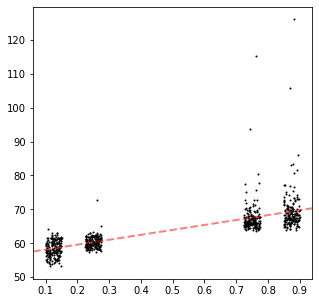

In [85]:
# predicted shift by cue probability
fig, ax = plt.subplots(figsize=(5, 5))
x = bayes_prediction_fit_df.condition_type
y = bayes_prediction_fit_df._inflection
ax.scatter(x + (np.random.uniform(size=len(x)) - 0.5) * 0.05, y, s = 1, color = 'k')
m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
ax.plot(x2, m * x2 + b, color="red", lw=2, ls="dashed", alpha=0.5)
ax.set_xlim(x2)

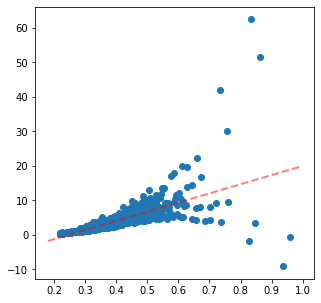

In [86]:
fig, ax = plt.subplots(figsize=(5, 5))

x = 1 / np.log(1+bayes_prediction_fit_df._slope.values)
y = (bayes_prediction_fit_df._inflection.values - 63.5) * np.sign(bayes_prediction_fit_df.condition_type - 0.5)

ax.scatter(x,y)
m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
ax.plot(x2, m * x2 + b, color="red", lw=2, ls="dashed", alpha=0.5)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


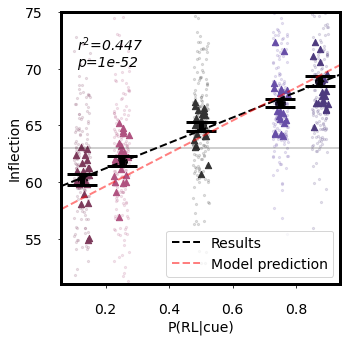

In [87]:
fig, ax = plt.subplots(figsize=(5, 5))
# ax.scatter(cue_strength, inflection_point)
# ax.errorbar(cue_strength, inflection_point, yerr=inf_pt_std, xerr=None, lw=3)
for idx, row in logistic_param_summary_df.iterrows():
    ax.scatter(
        [row.cue_strength["mean"]],
        [row._inflection["mean"]],
        # color=cdcp_colors["cue_pal"][row.name],
        color="k",
        s=100,
    )
    ax.errorbar(
        [row.cue_strength["mean"]],
        [row._inflection["mean"]],
        yerr=[row._inflection["std"] / np.sqrt(row._inflection["len"])],
        # color=cdcp_colors["cue_pal"][row.name],
        color="k",
        lw=5,
        #elinewidth=15,
        #barsabove=True,
        capsize=15, capthick=3
    )
    ax.scatter(
        fit_df_interp[fit_df_interp["cue"] == row.name].cue_strength
        + (
            np.random.uniform(
                size=len(fit_df_interp[fit_df_interp["cue"] == row.name].cue_strength)
            )
            - 0.5
        )
        * 0.05,
        fit_df_interp[fit_df_interp["cue"] == row.name]._inflection,
        color=cdcp_colors["cue_pal"][row.name],
        s=5,
        alpha=0.15,
    )

    cue_birds = logistic_param_summary_df_bird[
        logistic_param_summary_df_bird.index.get_level_values("cue") == idx
    ]

    ax.scatter(
        np.array([cue_birds.cue_strength["mean"]])+ (
            np.random.uniform(
                size=len(cue_birds._inflection["mean"])
            )
            - 0.5
        )
        * 0.05,
        [cue_birds._inflection["mean"]],
        color=cdcp_colors["cue_pal"][row.name],
        s=40,
        marker="^",
        alpha=1,
    )


bound = 12
ax.set_ylim([63 - bound, 63 + bound])
ax.axhline(63, color="k",  alpha = 0.25)# ls="dashed",

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)
ax.set_xlabel("P(RL|cue)", fontsize=14)
ax.set_ylabel("Inflection", fontsize=14)

y = fit_df_interp._inflection.values
x = fit_df_interp.cue_strength.values

m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
ax.plot(x2, m * x2 + b, color="k", lw=2, ls="dashed", alpha=1, label="Results")
ax.set_xlim(x2)

ax.text(
    x2[0] + 0.05,
    np.array(ax.get_ylim())[1] - 2,
    "r$^2$={}\np={:g}".format(round(correlation, 3), float('{:.1g}'.format(p_value))),
    horizontalalignment="left",
    verticalalignment="top",
    fontsize=14,
    color='k',
    fontweight='regular',
    style='italic',
);

### PLOT MODEL prediction

x = bayes_prediction_fit_df.condition_type
y = bayes_prediction_fit_df._inflection
#ax.scatter(x, y)
m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
ax.plot(x2, m * x2 + b, color="red", lw=2, ls="dashed", alpha=0.5, label="Model prediction")
ax.set_xlim(x2)
ax.legend(fontsize=14)


ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'cue_shift_with_model', save_pdf=True)
plt.show()

In [88]:
shifts = {}
for bi, bird in enumerate(tqdm(subjects)):
    shifts[bird] = {}
    for interp in fit_df_interp.interp.unique():
        shifts[bird][interp] = {}
        for cue in fit_df_interp.cue.unique():
            try:
                shifts[bird][interp][cue] = fit_df_interp[
                    (fit_df_interp.bird == bird) &
                    (fit_df_interp.cue == cue) &
                    (fit_df_interp.interp == interp)

                ].iloc[0]._inflection
            except IndexError as e:
                print(bird, interp, cue, e)
shifts_df = pd.concat([pd.DataFrame(shifts[bird]).T for bird in shifts.keys()])

  0%|          | 0/20 [00:00<?, ?it/s]

B1188 CE NC single positional indexer is out-of-bounds
B1188 CE CL0 single positional indexer is out-of-bounds
B1188 CE CN single positional indexer is out-of-bounds
B1188 CE CR1 single positional indexer is out-of-bounds
B1188 CE CL1 single positional indexer is out-of-bounds
B1188 CE CR0 single positional indexer is out-of-bounds
B1188 BG NC single positional indexer is out-of-bounds
B1188 BG CL0 single positional indexer is out-of-bounds
B1188 BG CN single positional indexer is out-of-bounds
B1188 BG CR1 single positional indexer is out-of-bounds
B1188 BG CL1 single positional indexer is out-of-bounds
B1188 BG CR0 single positional indexer is out-of-bounds
B1188 CF NC single positional indexer is out-of-bounds
B1188 CF CL0 single positional indexer is out-of-bounds
B1188 CF CN single positional indexer is out-of-bounds
B1188 CF CR1 single positional indexer is out-of-bounds
B1188 CF CL1 single positional indexer is out-of-bounds
B1188 CF CR0 single positional indexer is out-of-bound

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  war

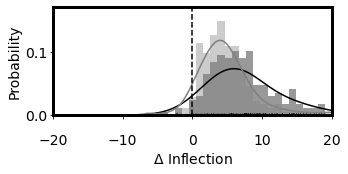

In [89]:
fig, ax = plt.subplots(ncols=1, figsize=(5,2))

sns.distplot(
    list(shifts_df.CL1 - shifts_df.CR1),
    bins=np.linspace(-20,20,40),
    color='black',
    ax=ax,
    rug=True,
    kde=True,
)
sns.distplot(
    list(shifts_df.CL0 - shifts_df.CR0),
    bins=np.linspace(-20,20,40),
    color='grey',
    ax=ax,
    rug=True,
    kde=True,
)
ax.set_xlim([-20, 20])
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)
ax.set_xlabel('$\Delta$ Inflection', fontsize=14)
ax.set_ylabel('Probability', fontsize=14)
ax.axvline(0, color="k", ls="dashed")
ax.set_yticks([0,0.1])
for tick in ax.get_yaxis().get_major_ticks():
    tick.set_pad(2.)

ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'cue_shift_hist', save_pdf=True)
plt.show()

In [90]:
x = np.stack([list(shifts_df.CL1 - shifts_df.CR1), list(shifts_df.CL0 - shifts_df.CR0)]).T
x.shape

(180, 2)

In [91]:
scipy.stats.ttest_1samp(x.flatten()[np.isnan(x.flatten()) == False], 0)

Ttest_1sampResult(statistic=18.55633840809095, pvalue=5.742730304505903e-54)

In [92]:
len(x.flatten()[np.isnan(x.flatten()) == False])

350

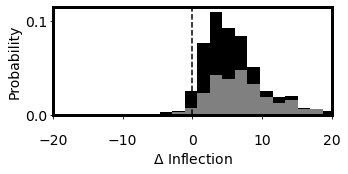

In [93]:
fig, ax = plt.subplots(ncols=1, figsize=(5,2))
ax.hist(x, bins=40,  histtype='bar', stacked=True, color = ['grey', 'black'], density=True);
ax.set_xlim([-20, 20])
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)
ax.set_xlabel('$\Delta$ Inflection', fontsize=14)
ax.set_ylabel('Probability', fontsize=14)
ax.axvline(0, color="k", ls="dashed")
ax.set_yticks([0,0.1])
for tick in ax.get_yaxis().get_major_ticks():
    tick.set_pad(2.)

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


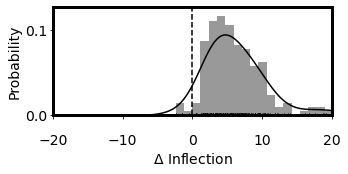

In [94]:
fig, ax = plt.subplots(ncols=1, figsize=(5,2))

sns.distplot(
    (shifts_df.CL0 + shifts_df.CL1)/2 - (shifts_df.CR0 + shifts_df.CR1)/2,
    bins=40,
    color='k',
    ax=ax,
    rug=True,
    kde=True,
)

ax.set_xlim([-20, 20])
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)
ax.set_xlabel('$\Delta$ Inflection', fontsize=14)
ax.set_ylabel('Probability', fontsize=14)
ax.axvline(0, color="k", ls="dashed")
ax.set_yticks([0,0.1])
for tick in ax.get_yaxis().get_major_ticks():
    tick.set_pad(2.)

### plot delta inflection by sigma

In [95]:
shift_direction = {
    'CL0': -1,
    'CL1': -1,
    'CR0': 1,
    'CR1': 1,
    'CN': np.nan,
    'NC': np.nan,
    'N': np.nan,
}

In [96]:
bayes_fit_df_interp["cued_inflection_shift"] = [shift_direction[row.cue]*(63.5 - row.bayesian_inflection) for idx, row in bayes_fit_df_interp.iterrows()]

In [97]:
mask = bayes_fit_df_interp.cue.isin(['N', 'NC', 'CN']) == False

cat = bayes_fit_df_interp[mask].interp.values
pal = {i:j for i, j in zip(np.unique(cat), sns.color_palette('tab10', len(np.unique(cat))))}
cols = [pal[i] for i in cat]

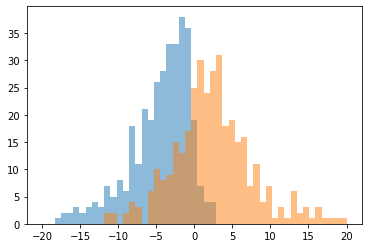

In [98]:
plt.hist((63.5 - bayes_fit_df_interp.bayesian_inflection.values)[bayes_fit_df_interp.cue.isin(['CL0', 'CL1'])], bins = np.linspace(-20,20, 50), alpha = 0.5);
plt.hist((63.5 - bayes_fit_df_interp.bayesian_inflection.values)[bayes_fit_df_interp.cue.isin(['CR0', 'CR1'])], bins = np.linspace(-20,20, 50), alpha = 0.5);

In [99]:
bayes_fit_df_interp[:3]

,bird,cue,interp,n_points,bayesian_model,params_dict,index,sigma_likelihood,alpha_overall_attention,beta_categorical_attention,delta_cue_attention,gamma_side_bias,bayesian_slope,bayesian_min,bayesian_max,bayesian_inflection,bayesian_4param_model,bayesian_r_squared,bayesian_abs_inflection,cued_inflection_shift
0,B1174,NC,AE,14538,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 6.457730202151546, 'alpha...",0,6.457730,0.063742,0.198309,0.977811,0.473227,16.679781,0.115005,0.867629,63.530255,<lmfit.minimizer.MinimizerResult object at 0x7...,0.999859,0.030255,NaN
1,B1174,CL0,AE,6876,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 4.258037094104594, 'alpha...",1,4.258037,0.170191,0.048853,0.981746,0.484030,26.21499,0.093812,0.877038,64.859159,<lmfit.minimizer.MinimizerResult object at 0x7...,0.999885,1.359159,1.359159
2,B1174,CN,AE,1606,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 4.533689892680126, 'alpha...",2,4.533690,0.130808,0.130919,0.003751,0.512038,23.784747,0.125208,0.882155,63.43971,<lmfit.minimizer.MinimizerResult object at 0x7...,0.999929,0.06029,NaN


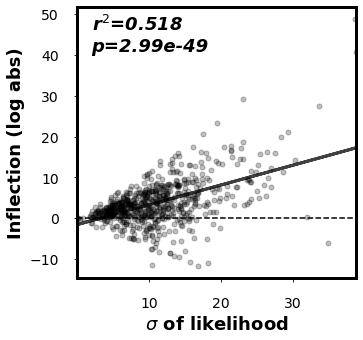

In [100]:
fig, ax = plt.subplots(figsize=(5, 5))
x = bayes_fit_df_interp[mask].sigma_likelihood.values.astype('float')
y= bayes_fit_df_interp[mask].cued_inflection_shift.values.astype('float')

correlation_sigma, p_value_sigma = scipy.stats.pearsonr(x,y)

#x = np.log(x)
#y = np.log(y)
ax.scatter(
    x,
    y,
    s = 25,
    alpha = 0.25,
    #c = cols
    c = 'k'
)
m, b = np.polyfit(x, y, 1)

ax.plot(x, m*x + b, color = 'black', lw=3, ls = 'solid', alpha = 0.75)
ax.set_xlim([np.min(x), np.max(x)])
#ax.set_xlim([-1,30])
#ax.set_ylim([-1,25])

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)
ax.set_xlabel("$\sigma$ of likelihood", fontsize=18, fontweight="bold")
ax.set_ylabel("Inflection (log abs)", fontsize=18, fontweight="bold")

ax.text(
    2,
    np.array(ax.get_ylim())[1] - 2,
    "r$^2$={}\np={:g}".format(round(correlation_sigma, 3), float('{:.3g}'.format(p_value_sigma))),
    horizontalalignment="left",
    verticalalignment="top",
    fontsize=18,
    color='k',
    fontweight='bold',
    style='italic',
);
ax.axhline(0, ls='dashed', color = 'k')

#ensure_dir(FIGURE_DIR / 'behavioral_results')
#save_fig(FIGURE_DIR / 'behavioral_results' / 'slope_shift', save_pdf=True)
#plt.show()

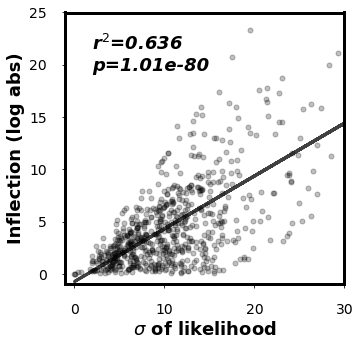

In [101]:
fig, ax = plt.subplots(figsize=(5, 5))
x = bayes_fit_df_interp[mask].sigma_likelihood.values.astype('float')
y= bayes_fit_df_interp[mask].bayesian_abs_inflection.values.astype('float')

correlation_sigma, p_value_sigma = scipy.stats.pearsonr(x,y)

#x = np.log(x)
#y = np.log(y)
ax.scatter(
    x,
    y,
    s = 25,
    alpha = 0.25,
    #c = cols
    c = 'k'
)
m, b = np.polyfit(x, y, 1)

ax.plot(x, m*x + b, color = 'black', lw=3, ls = 'solid', alpha = 0.75)
ax.set_xlim([np.min(x), np.max(x)])
ax.set_xlim([-1,30])
ax.set_ylim([-1,25])

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)
ax.set_xlabel("$\sigma$ of likelihood", fontsize=18, fontweight="bold")
ax.set_ylabel("Inflection (log abs)", fontsize=18, fontweight="bold")

ax.text(
    2,
    np.array(ax.get_ylim())[1] - 2,
    "r$^2$={}\np={:g}".format(round(correlation_sigma, 3), float('{:.3g}'.format(p_value_sigma))),
    horizontalalignment="left",
    verticalalignment="top",
    fontsize=18,
    color='k',
    fontweight='bold',
    style='italic',
);

ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'slope_shift', save_pdf=True)
plt.show()

##### plot model prediction for delta inflection by sigma

In [102]:
bayes_prediction_fit_df['_abs_inflection'] = np.abs(bayes_prediction_fit_df._inflection - 63.5)

In [103]:
#mask = bayes_prediction_fit_df.cue.isin(['N', 'NC', 'CN']) == False
mask = bayes_prediction_fit_df.cue.isin(['asfds']) == False

cat = bayes_prediction_fit_df[mask].interp.values
pal = {i:j for i, j in zip(np.unique(cat), sns.color_palette('tab10', len(np.unique(cat))))}
cols = [pal[i] for i in cat]

Text(0, 0.5, 'Inflection (log abs)')

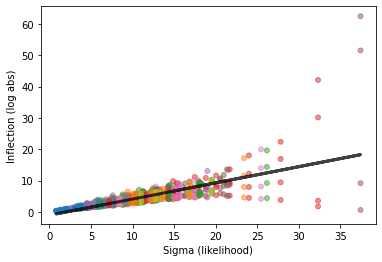

In [104]:
fig, ax = plt.subplots()
x = bayes_prediction_fit_df[mask]._likelihood.values.astype('float')
y= bayes_prediction_fit_df[mask]._abs_inflection.values.astype('float')
ax.scatter(
    x,
    y,
    s = 25,
    alpha = 0.5,
    c = cols
)
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color = 'black', lw=3, ls = 'solid', alpha = 0.75)

ax.set_xlabel('Sigma (likelihood)')
ax.set_ylabel('Inflection (log abs)')

### shift in inflection by slope

In [105]:
fit_df_interp[:3]

,bird,cue,interp,n_points,_min,_max,_inflection,_slope,model,y_interp,r_squared,cue_strength
0,B1174,NC,AE,14538,0.112693,0.903653,64.036638,14.918588,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.11269340812421869, 0.11269340812421869, 0.1...",0.538664,0.50
1,B1174,CL0,AE,6876,0.099140,0.880312,64.357732,27.363792,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.09913953431260725, 0.09913953431260725, 0.0...",0.533202,0.75
2,B1174,CN,AE,1606,0.131581,0.884359,64.226503,24.816837,<lmfit.minimizer.MinimizerResult object at 0x7...,"[0.1315810264285665, 0.1315810264285665, 0.131...",0.519944,0.50


In [106]:
bayes_fit_df_interp[:3]

,bird,cue,interp,n_points,bayesian_model,params_dict,index,sigma_likelihood,alpha_overall_attention,beta_categorical_attention,delta_cue_attention,gamma_side_bias,bayesian_slope,bayesian_min,bayesian_max,bayesian_inflection,bayesian_4param_model,bayesian_r_squared,bayesian_abs_inflection,cued_inflection_shift
0,B1174,NC,AE,14538,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 6.457730202151546, 'alpha...",0,6.457730,0.063742,0.198309,0.977811,0.473227,16.679781,0.115005,0.867629,63.530255,<lmfit.minimizer.MinimizerResult object at 0x7...,0.999859,0.030255,NaN
1,B1174,CL0,AE,6876,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 4.258037094104594, 'alpha...",1,4.258037,0.170191,0.048853,0.981746,0.484030,26.21499,0.093812,0.877038,64.859159,<lmfit.minimizer.MinimizerResult object at 0x7...,0.999885,1.359159,1.359159
2,B1174,CN,AE,1606,<lmfit.minimizer.MinimizerResult object at 0x7...,"{'sigma_likelihood': 4.533689892680126, 'alpha...",2,4.533690,0.130808,0.130919,0.003751,0.512038,23.784747,0.125208,0.882155,63.43971,<lmfit.minimizer.MinimizerResult object at 0x7...,0.999929,0.06029,NaN


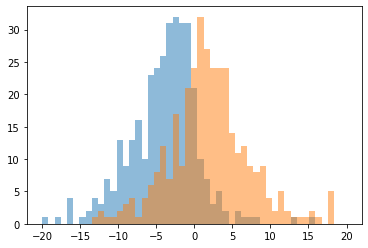

In [107]:
plt.hist((63.5 - fit_df_interp._inflection.values)[fit_df_interp.cue.isin(['CL0', 'CL1'])], bins = np.linspace(-20,20, 50), alpha = 0.5);
plt.hist((63.5 - fit_df_interp._inflection.values)[fit_df_interp.cue.isin(['CR0', 'CR1'])], bins = np.linspace(-20,20, 50), alpha = 0.5);

In [108]:
fit_df_interp["cued_inflection_shift"] = [shift_direction[row.cue]*(63.5 - row._inflection) for idx, row in fit_df_interp.iterrows()]

In [109]:
mask = fit_df_interp.cue.isin(['N', 'NC', 'CN']) == False

In [110]:
x = 1 / np.log(fit_df_interp[mask]._slope.values.astype('float')+1)
y= fit_df_interp[mask].cued_inflection_shift.values.astype('float')

correlation_sigma, p_value_sigma = scipy.stats.pearsonr(x,y)


In [111]:
print(len(x))

700


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


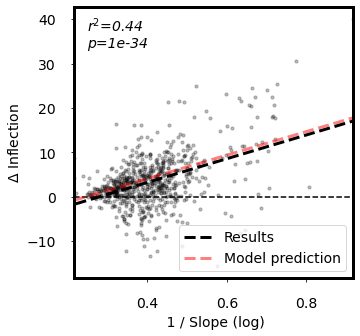

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))
x = 1 / np.log(fit_df_interp[mask]._slope.values.astype('float')+1)
y= fit_df_interp[mask].cued_inflection_shift.values.astype('float')

correlation_sigma, p_value_sigma = scipy.stats.pearsonr(x,y)

#x = np.log(x)
#y = np.log(y)
ax.scatter(
    x,
    y,
    s = 10,
    alpha = 0.25,
    #c = cols
    c = 'k'
)
m, b = np.polyfit(x, y, 1)

x2 = np.array(ax.get_xlim())
ax.plot(x2, m*x2 + b, color = 'k', lw=3, ls = 'dashed', alpha = 1, label="Results")
ax.set_xlim([np.min(x), np.max(x)])
#ax.set_xlim([-1,30])
#ax.set_ylim([-1,25])

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.tick_params(axis="both", labelsize=14, pad=15)
ax.set_xlabel(" 1 / Slope (log)", fontsize=14, fontweight="regular")
ax.set_ylabel("$\Delta$ Inflection", fontsize=14, fontweight="regular")

ax.text(
    0.25,
    np.array(ax.get_ylim())[1] - 2,
    "r$^2$={}\np={:g}".format(round(correlation_sigma, 3), float('{:.1g}'.format(p_value_sigma))),
    horizontalalignment="left",
    verticalalignment="top",
    fontsize=14,
    color='k',
    fontweight='regular',
    style='italic',
);
ax.axhline(0, ls='dashed', color = 'k')

#ensure_dir(FIGURE_DIR / 'behavioral_results')
#save_fig(FIGURE_DIR / 'behavioral_results' / 'slope_shift', save_pdf=True)
#plt.show()

### Plot bayesian model fit
x = 1 / np.log(1+bayes_prediction_fit_df._slope.values)
y = (bayes_prediction_fit_df._inflection.values - 63.5) * np.sign(bayes_prediction_fit_df.condition_type - 0.5)

m, b = np.polyfit(x, y, 1)
x2 = np.array(ax.get_xlim())
ax.plot(x2, m * x2 + b, color="red", lw=3, ls="dashed", alpha=0.5, label="Model prediction")
ax.legend(fontsize='14', loc='lower right')

ensure_dir(FIGURE_DIR / 'behavioral_results')
save_fig(FIGURE_DIR / 'behavioral_results' / 'slope-related-cue_shift', save_pdf=True)
plt.show()

In [113]:
x = 1 / np.log(fit_df_interp[mask]._slope.values.astype('float')+1)